In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pathlib import Path
from save_experiment import save_experiment, save_ml_experiment
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import warnings

In [38]:
df = pd.read_csv('../processed_data/hp_energy_production_with_engineered_features_1.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.dropna()
df = df[df['Station'] == 'Amberd 3']

features = [
    'Water_Flow_m3_s', 'avgtempC', 'totalprecipMM', 'humidity', 'pressureMB',
    'Month', 'WaterFlow_Diff_1d', 'WaterFlow_Diff_7d', 'WaterFlow_3day_avg',
    'WaterFlow_7day_avg', 'Temp_Deviation', 'WaterFlow_Humidity',
    'month_sin', 'month_cos', 'Prev_Day_Efficiency', 'Prev_Week_Efficiency'
]
target = 'Normalized_Efficiency'

In [39]:
df_num = df.select_dtypes(include=['number']).dropna()
X = df_num.drop(columns=['Normalized_Efficiency'])
y = df_num['Normalized_Efficiency']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [40]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(n_estimators=500, max_depth=10, learning_rate=0.05, random_state=42, verbosity=0),
    "LightGBM": LGBMRegressor(n_estimators=500, max_depth=10, learning_rate=0.05, random_state=42, verbose=-1),
    "CatBoost": CatBoostRegressor(n_estimators=500, depth=10, learning_rate=0.05, random_state=42, verbose=0),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "Support Vector Regression": SVR(),
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=10),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "Multiple Linear Regression (MLR)": LinearRegression(),
    "SVR": SVR()
}

In [41]:
results = {}

for name, model in tqdm(models.items()):
    if name in ['MLP Regressor']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'Prediction': y_pred
    }

/Users/elvinanosrati/Capstone/energy-production-analysis/myenv-py311/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.0735e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:18<00:00,  1.30s/it]


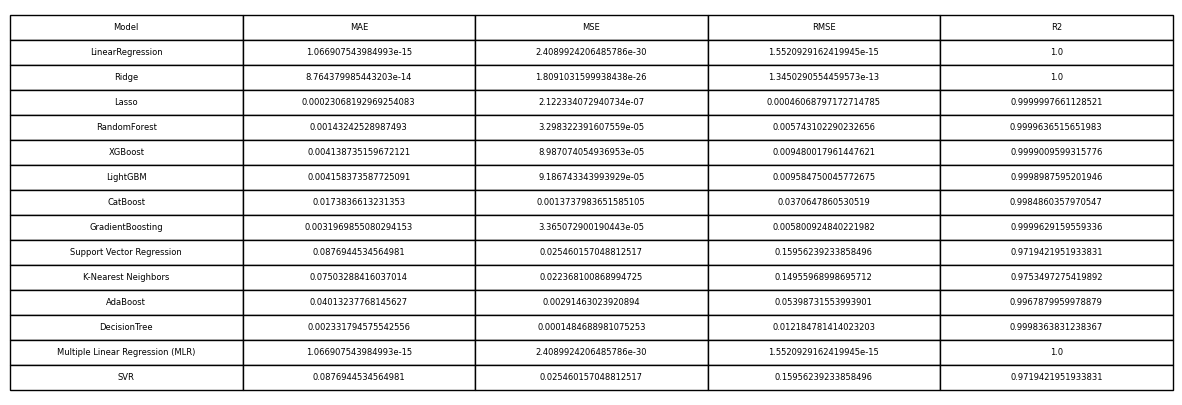

In [42]:
metrics_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MAE': [results[m]['MAE'] for m in results],
    'MSE': [results[m]['MSE'] for m in results],
    'RMSE': [results[m]['RMSE'] for m in results],
    'R2': [results[m]['R2'] for m in results]
})

table_fig, ax = plt.subplots(figsize=(10,5))
ax.axis('off')
table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(6)
table.scale(1.5, 1.5)
plt.show()
plt.close()

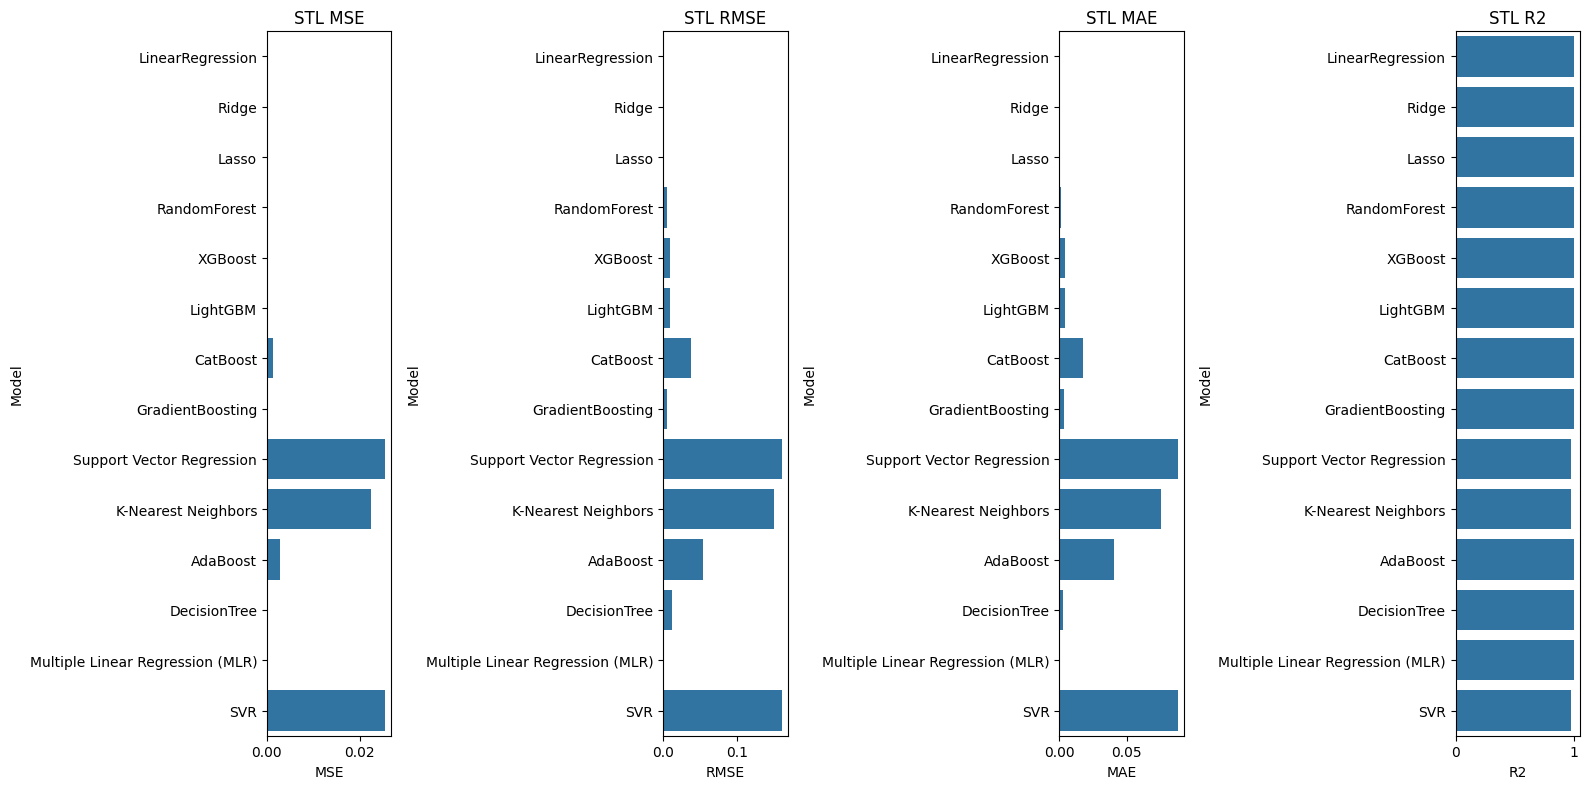

In [43]:
barplot_fig = plt.figure(figsize=(16, 8))
for i, metric in enumerate(["MSE", "RMSE", "MAE", "R2"]):
    plt.subplot(1, 4, i + 1)
    sns.barplot(y="Model", x=metric, data=metrics_df)
    plt.title("STL " + metric)
    plt.tight_layout()
plt.show()
plt.close()

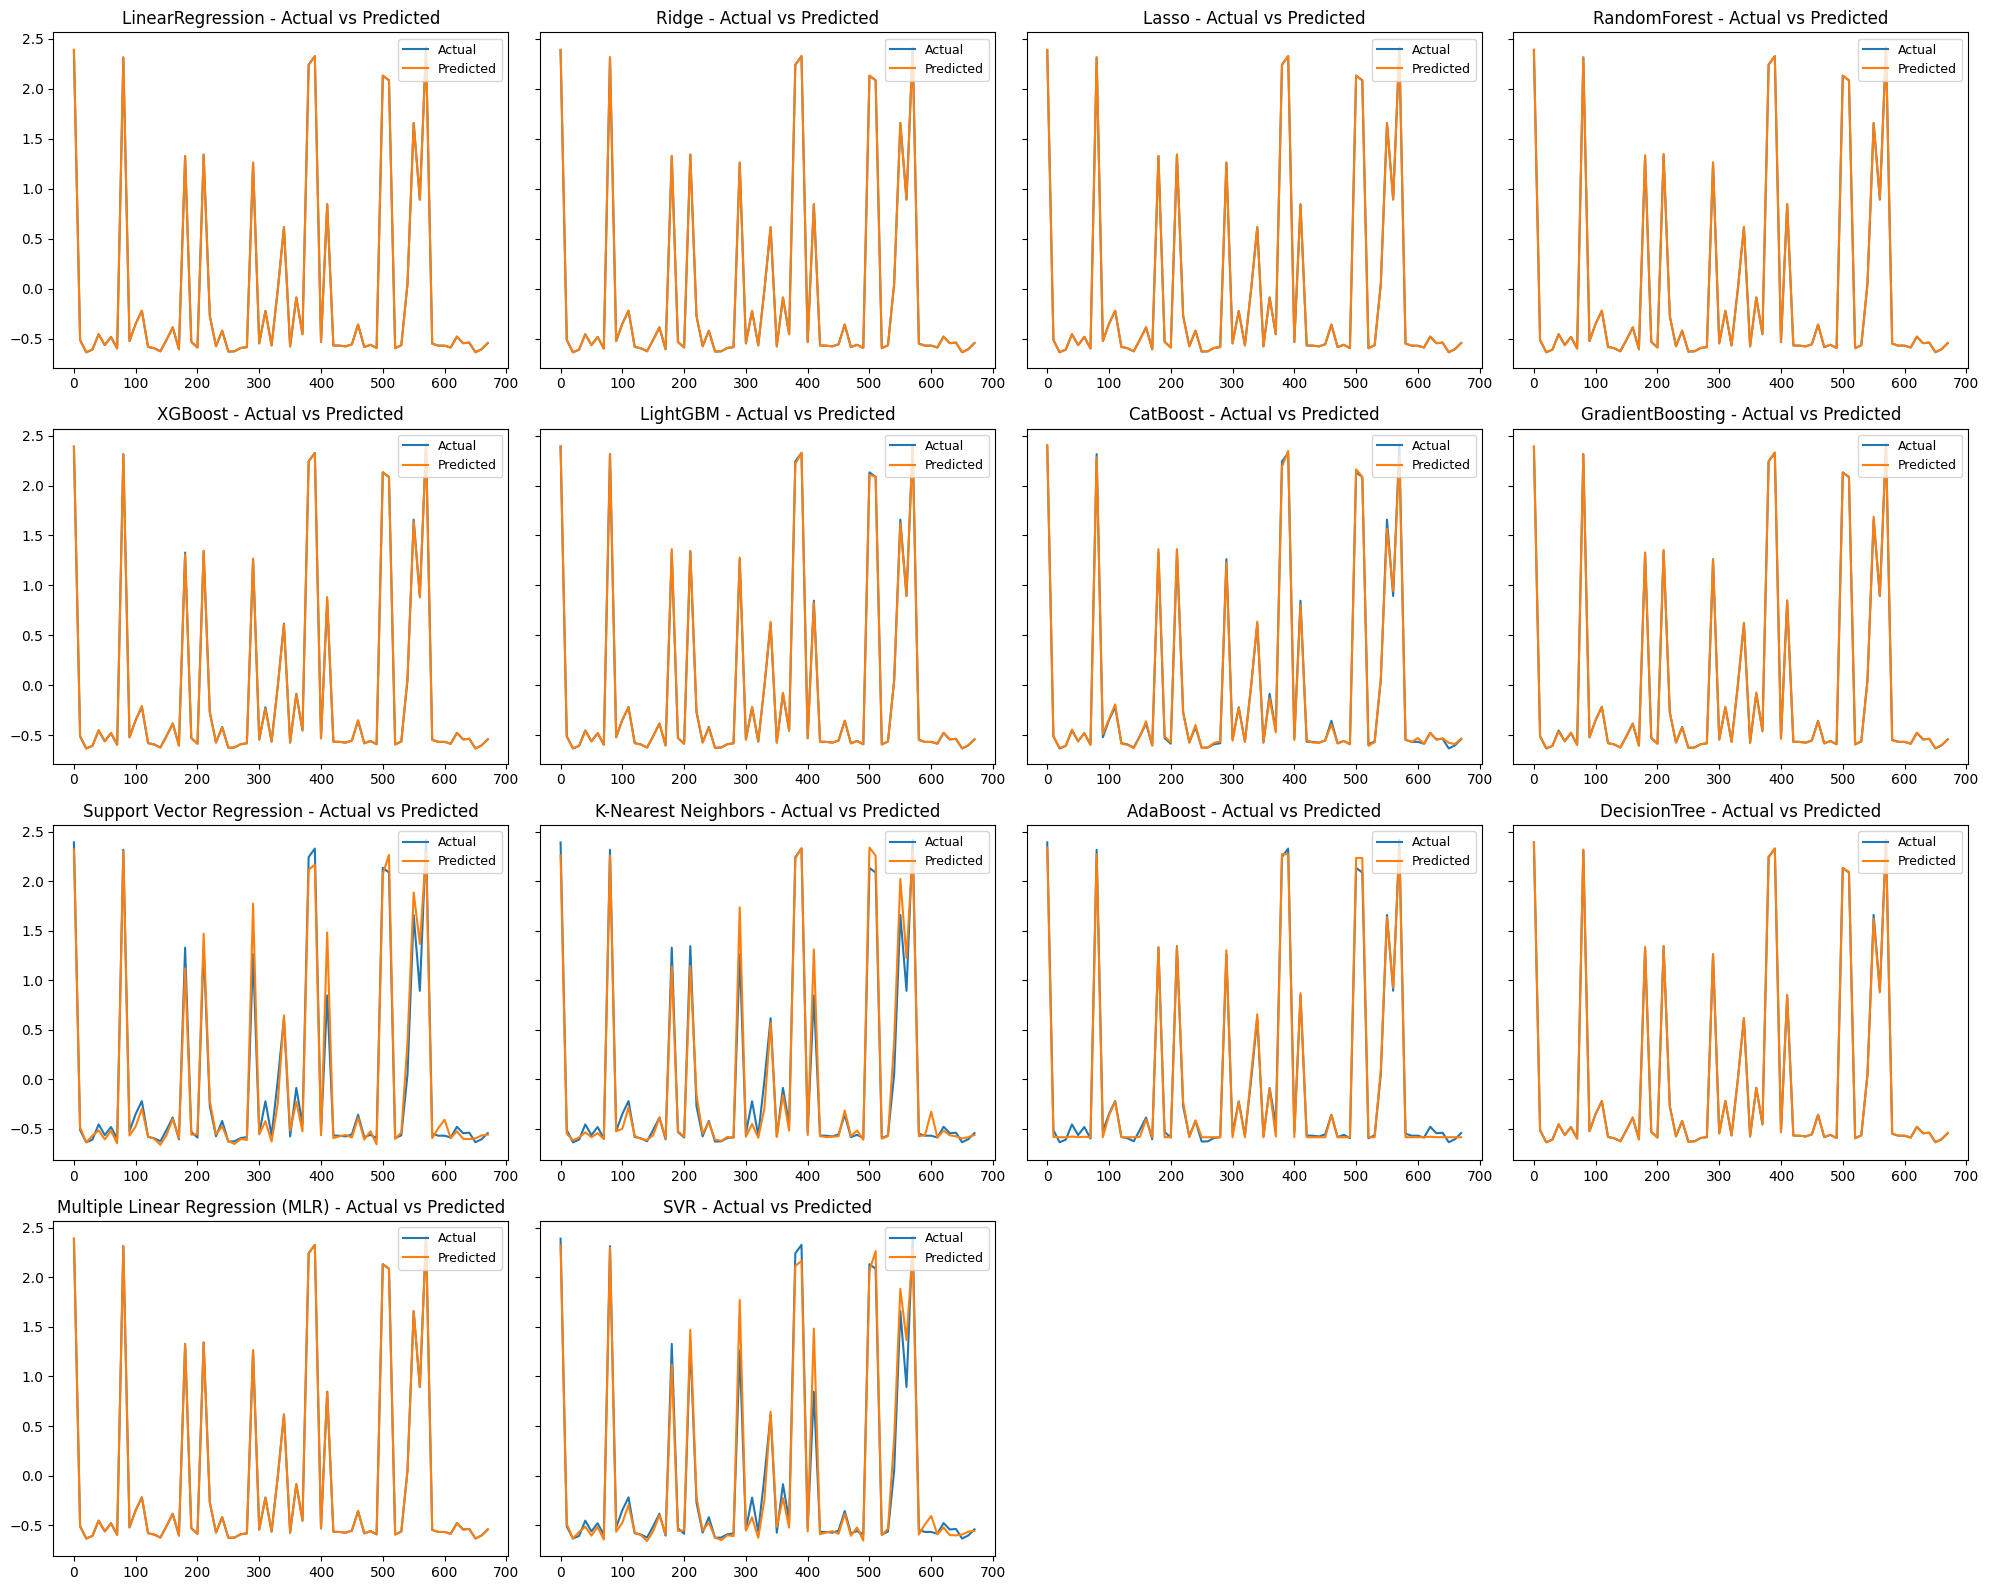

In [44]:
pred_figs = {}
cols_stl = 4
num_models_stl = len(results)
rows_stl = int(np.ceil(num_models_stl / cols_stl))
idx = np.arange(len(y_test))[::10]

fig, axes = plt.subplots(rows_stl, cols_stl, figsize=(20, 16), sharey='row')
axes = axes.flatten()

for i, (name, res) in enumerate(results.items()):
    ax = axes[i]
    ax.plot(idx, y_test.values[idx],        label='Actual')
    ax.plot(idx, res['Prediction'][idx],    label='Predicted')
    ax.set_title(f"{name} - Actual vs Predicted")
    ax.legend(fontsize=9, loc="upper right")

for j in range(len(results), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
pred_figs["AllModels"] = fig
plt.show()
plt.close()

In [12]:
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

X_train_tensor           = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor            = torch.tensor(X_test_scaled,  dtype=torch.float32)
X_train_tensor_tabular = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor_tabular  = torch.tensor(X_test_scaled,  dtype=torch.float32)
y_train_tensor           = torch.tensor(y_train.values,    dtype=torch.float32).view(-1, 1)
y_test_tensor            = torch.tensor(y_test.values,     dtype=torch.float32).view(-1, 1)

train_dataset            = TensorDataset(X_train_tensor,        y_train_tensor)
test_dataset             = TensorDataset(X_test_tensor,         y_test_tensor)  

train_dataset_tabular    = TensorDataset(X_train_tensor_tabular, y_train_tensor)
test_dataset_tabular     = TensorDataset(X_test_tensor_tabular,  y_test_tensor)

train_loader             = DataLoader(train_dataset,          batch_size=64,  shuffle=True)
test_loader              = DataLoader(test_dataset,           batch_size=64,  shuffle=False)
train_loader_tabular     = DataLoader(train_dataset_tabular,  batch_size=256, shuffle=True)
test_loader_tabular      = DataLoader(test_dataset_tabular,   batch_size=256, shuffle=False)

In [13]:
def reshape_input(model, xb):
    rnn_models = (LSTMNet, BiLSTMNet, RNNNet, GRUNet, CNNLSTM, DeepLSTMNet, Seq2SeqLSTM, CNNBiLSTM, GRUCNN)
    cnn_models = (CNN1D, CNNLSTM, CNNBiLSTM, GRUCNN)
    tcn_models = (TCN, TCNLSTM)

    if isinstance(model, tcn_models):
        if xb.dim() == 2:
            xb = xb.unsqueeze(-1)
            xb = xb.transpose(1, 2)
    elif isinstance(model, rnn_models + cnn_models):
        if xb.dim() == 2:
            xb = xb.unsqueeze(1)
    return xb

In [14]:
class Net1(nn.Module):
    def __init__(self, input_dim):
        super(Net1, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)


class Net2(nn.Module):
    def __init__(self, input_dim):
        super(Net2, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)


class Net3(nn.Module):
    def __init__(self, input_dim):
        super(Net3, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

class Net4(nn.Module):
    def __init__(self, input_dim):
        super(Net4, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

In [15]:
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(LSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])


class BiLSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.3):
        super(BiLSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers,
                            dropout=dropout, batch_first=True, bidirectional=True)
        self.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(hidden_dim * 2, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])


class RNNNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(RNNNet, self).__init__()
        self.rnn = nn.RNN(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])


class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(GRUNet, self).__init__()
        self.gru = nn.GRU(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

class CNN1D(nn.Module):
    def __init__(self, input_dim, num_filters, num_layers, kernel_size, dropout):
        super().__init__()
        layers = []
        in_ch = input_dim
        for _ in range(num_layers):
            layers += [
                nn.Conv1d(in_ch, num_filters, kernel_size, padding=kernel_size//2),
                nn.ReLU(),
                nn.Dropout(dropout)
            ]
            in_ch = num_filters
        self.features = nn.Sequential(*layers)
        self.fc = nn.Linear(num_filters, 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        out = self.features(x)
        out = out.mean(dim=2)
        return self.fc(out)


class CNNLSTM(nn.Module):
    def __init__(
        self,
        input_dim: int,
        cnn_filters: list[int] = [64, 64],
        cnn_kernel_size: int = 3,
        lstm_hidden: int = 128,
        lstm_layers: int = 2,
        dropout: float = 0.3
    ):
        super().__init__()
        if isinstance(cnn_filters, int):
            cnn_filters = [cnn_filters]
        convs, in_ch = [], 1
        for out_ch in cnn_filters:
            convs += [
                nn.Conv1d(in_ch, out_ch, kernel_size=cnn_kernel_size,
                          padding=cnn_kernel_size//2),
                nn.ReLU(),
                nn.Dropout(dropout)
            ]
            in_ch = out_ch
        self.cnn = nn.Sequential(*convs)
        self.lstm = nn.LSTM(
            input_size=in_ch,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0.0
        )
        self.head = nn.Linear(lstm_hidden, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if x.dim() == 4:
            x = x.squeeze(1)

        if x.dim() == 2:
            b, f = x.shape
            x = x.unsqueeze(1)       
            x = self.cnn(x)          
            x = x.transpose(1, 2)     
            out, _ = self.lstm(x)     
            return self.head(out[:, -1, :])

        elif x.dim() == 3:
            b, s, f = x.shape
            x = x.reshape(b * s, f).unsqueeze(1)  
            x = self.cnn(x)                      
            x = x.mean(dim=2)                     
            x = x.view(b, s, -1)                  
            out, _ = self.lstm(x)                 
            return self.head(out[:, -1, :])

        else:
            raise ValueError(f"Unsupported input dims: {x.dim()}")


class FNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

class DeepFNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

class DeepLSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=4, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)

        self.downsample = (nn.Conv1d(in_channels, out_channels, 1)
                           if in_channels != out_channels else None)
        self.relu = nn.ReLU()

    def forward(self, x):
        L = x.size(2) 
        out = self.conv1(x)[..., :L]    
        out = self.bn1(out); out = self.relu(out); out = self.dropout1(out)

        out = self.conv2(out)[..., :L]
        out = self.bn2(out); out = self.relu(out); out = self.dropout2(out)

        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride, dilation, dropout):
        super().__init__()
        padding = (kernel_size - 1) * dilation // 2

        self.conv1 = nn.Conv1d(
            in_channels, out_channels, kernel_size,
            stride=stride, padding=padding, dilation=dilation
        )
        self.bn1      = nn.BatchNorm1d(out_channels)
        self.relu1    = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(
            out_channels, out_channels, kernel_size,
            stride=stride, padding=padding, dilation=dilation
        )
        self.bn2      = nn.BatchNorm1d(out_channels)
        self.relu2    = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.downsample = (
            nn.Conv1d(in_channels, out_channels, 1)
            if in_channels != out_channels else None
        )
        self.final_relu = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        res = x if self.downsample is None else self.downsample(x)
        return self.final_relu(out + res)


class TCN(nn.Module):
    def __init__(self, input_dim, num_channels, kernel_size=3, dropout=0.2):
        super().__init__()
        layers = []
        for i, out_ch in enumerate(num_channels):
            in_ch   = input_dim if i == 0 else num_channels[i-1]
            dilation = 2 ** i
            layers.append(
                TemporalBlock(
                    in_channels=in_ch,
                    out_channels=out_ch,
                    kernel_size=kernel_size,
                    stride=1,
                    dilation=dilation,
                    dropout=dropout
                )
            )
        self.network = nn.Sequential(*layers)
        self.fc      = nn.Linear(num_channels[-1], 1)

    def forward(self, x):
        x = x.transpose(1, 2)     
        y = self.network(x)       
        y = y[:, :, -1]           
        return self.fc(y)    

class CNNBiLSTM(nn.Module):
    def __init__(self, input_dim, cnn_filters=32, lstm_hidden=64, lstm_layers=2, dropout=0.3):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(input_dim, cnn_filters, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.bilstm = nn.LSTM(
            input_size=cnn_filters,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )
        self.fc = nn.Linear(2 * lstm_hidden, 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.cnn(x)
        x = x.transpose(1, 2)
        out, _ = self.bilstm(x)
        return self.fc(out[:, -1, :])

class GRUCNN(nn.Module):
    def __init__(self, input_dim, gru_hidden=64, cnn_filters=32, kernel_size=3, dropout=0.3):
        super().__init__()
        self.gru = nn.GRU(input_dim, gru_hidden, batch_first=True)
        self.cnn = nn.Sequential(
            nn.Conv1d(gru_hidden, cnn_filters, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.fc = nn.Linear(cnn_filters, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.cnn(out.transpose(1, 2))
        out = out.mean(dim=2)
        return self.fc(out)

class TCNLSTM(nn.Module):
    def __init__(self, input_dim, tcn_channels=[64,64], lstm_hidden=64, lstm_layers=1, kernel_size=3, dropout=0.3):
        super().__init__()
        self.tcn = TCN(input_dim, tcn_channels, kernel_size=kernel_size, dropout=dropout)
        self.lstm = nn.LSTM(input_size=tcn_channels[-1], hidden_size=lstm_hidden, num_layers=lstm_layers, batch_first=True)
        self.fc = nn.Linear(lstm_hidden, 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.tcn.network(x).transpose(1, 2)
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class Seq2SeqLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.3):
        super(Seq2SeqLSTM, self).__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        _, (hidden, cell) = self.encoder(x)
        dec_input = torch.zeros(x.size(0), 1, hidden.size(2)).to(x.device)
        out, _ = self.decoder(dec_input, (hidden, cell))
        return self.fc(out[:, -1, :])
  

In [16]:
def train_model(name, model, train_loader, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,epochs=1000, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    history = []
    for epoch in tqdm(range(1, epochs + 1)):
        model.train()
        running_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        
        model.eval()
        with torch.no_grad():
            y_train_pred = model(X_train_tensor)
            y_test_pred  = model(X_test_tensor)

            train_mse  = mean_squared_error(y_train_tensor.numpy(), y_train_pred.numpy())
            test_mse   = mean_squared_error(y_test_tensor.numpy(), y_test_pred.numpy())
            train_rmse = np.sqrt(train_mse)
            test_rmse  = np.sqrt(test_mse)
            train_mae  = mean_absolute_error(y_train_tensor.numpy(), y_train_pred.numpy())
            test_mae   = mean_absolute_error(y_test_tensor.numpy(), y_test_pred.numpy())
            train_r2   = r2_score(y_train_tensor.numpy(), y_train_pred.numpy())
            test_r2    = r2_score(y_test_tensor.numpy(), y_test_pred.numpy())

            history.append({
                "Model": name,
                "Epoch": epoch,
                "Train MSE": train_mse,
                "Test MSE": test_mse,
                "Train RMSE": train_rmse,
                "Test RMSE": test_rmse,
                "Train MAE": train_mae,
                "Test MAE": test_mae,
                "Train R2": train_r2,
                "Test R2": test_r2
            })

            if epoch % 10 == 0 or epoch == 1 or epoch == epochs:
                print(f"\nModel: {name} | Epoch: {epoch}/{epochs}")
                print(f"Train: MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R2: {train_r2:.4f}")
                print(f"Test:  MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}")
                
    return history

In [17]:
def train_ts_model(name, model, train_loader, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs=200, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

    history = []
    for epoch in tqdm(range(1, epochs + 1), desc=f"Training {name}"):
        model.train()
        running_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()    
            running_loss += loss.item()

        model.eval()
        with torch.no_grad():
            y_train_pred = model(X_train_tensor)
            y_test_pred  = model(X_test_tensor)

            train_mse = mean_squared_error(y_train_tensor.numpy(), y_train_pred.numpy())
            test_mse  = mean_squared_error(y_test_tensor.numpy(), y_test_pred.numpy())
            train_rmse = np.sqrt(train_mse)
            test_rmse  = np.sqrt(test_mse)
            train_mae = mean_absolute_error(y_train_tensor.numpy(), y_train_pred.numpy())
            test_mae  = mean_absolute_error(y_test_tensor.numpy(), y_test_pred.numpy())
            train_r2  = r2_score(y_train_tensor.numpy(), y_train_pred.numpy())
            test_r2   = r2_score(y_test_tensor.numpy(), y_test_pred.numpy())

            history.append({
                "Model": name,
                "Epoch": epoch,
                "Train MSE": train_mse,
                "Test MSE": test_mse,
                "Train RMSE": train_rmse,
                "Test RMSE": test_rmse,
                "Train MAE": train_mae,
                "Test MAE": test_mae,
                "Train R2": train_r2,
                "Test R2": test_r2
            })

            if epoch % 10 == 0 or epoch == 1 or epoch == epochs:
                print(f"\nModel: {name} | Epoch: {epoch}/{epochs}")
                print(f"Train: MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R2: {train_r2:.4f}")
                print(f"Test:  MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}")

    return history

In [18]:
input_dim = X_test_tensor_tabular.shape[1]

nets = {
    "Net1":   Net1(input_dim),
    "Net2":   Net2(input_dim),
    "Net3":   Net3(input_dim),
    "Net4":   Net4(input_dim)
}

nets_tabular = {
    "Net1":    Net1(input_dim),
    "Net2":    Net2(input_dim),
    "Net3":    Net3(input_dim),
    "Net4":    Net4(input_dim),
    "FNN":     FNN(input_dim),
    "DeepFNN": DeepFNN(input_dim)
}

In [19]:
results = []
for name, net in nets.items():
    results += train_model(name, net, train_loader, 
                               X_train_tensor, y_train_tensor, 
                               X_test_tensor, y_test_tensor,
                               epochs=100, lr=1e-3)
    
nn_metrics_df = pd.DataFrame(results)

  8%|████████▏                                                                                              | 8/100 [00:00<00:02, 40.19it/s]


Model: Net1 | Epoch: 1/100
Train: MSE: 0.0709, RMSE: 0.2662, MAE: 0.1795, R2: 0.9308
Test:  MSE: 0.0684, RMSE: 0.2615, MAE: 0.1765, R2: 0.9247

Model: Net1 | Epoch: 10/100
Train: MSE: 0.0017, RMSE: 0.0415, MAE: 0.0300, R2: 0.9983
Test:  MSE: 0.0022, RMSE: 0.0466, MAE: 0.0329, R2: 0.9976


 28%|████████████████████████████▌                                                                         | 28/100 [00:00<00:01, 45.49it/s]


Model: Net1 | Epoch: 20/100
Train: MSE: 0.0006, RMSE: 0.0247, MAE: 0.0182, R2: 0.9994
Test:  MSE: 0.0008, RMSE: 0.0278, MAE: 0.0197, R2: 0.9992


 38%|██████████████████████████████████████▊                                                               | 38/100 [00:00<00:01, 45.91it/s]


Model: Net1 | Epoch: 30/100
Train: MSE: 0.0003, RMSE: 0.0185, MAE: 0.0137, R2: 0.9997
Test:  MSE: 0.0004, RMSE: 0.0205, MAE: 0.0144, R2: 0.9995


 48%|████████████████████████████████████████████████▉                                                     | 48/100 [00:01<00:01, 44.63it/s]


Model: Net1 | Epoch: 40/100
Train: MSE: 0.0002, RMSE: 0.0150, MAE: 0.0109, R2: 0.9998
Test:  MSE: 0.0003, RMSE: 0.0173, MAE: 0.0121, R2: 0.9997


 58%|███████████████████████████████████████████████████████████▏                                          | 58/100 [00:01<00:00, 45.37it/s]


Model: Net1 | Epoch: 50/100
Train: MSE: 0.0002, RMSE: 0.0127, MAE: 0.0090, R2: 0.9998
Test:  MSE: 0.0002, RMSE: 0.0158, MAE: 0.0108, R2: 0.9997


 68%|█████████████████████████████████████████████████████████████████████▎                                | 68/100 [00:01<00:00, 46.89it/s]


Model: Net1 | Epoch: 60/100
Train: MSE: 0.0001, RMSE: 0.0116, MAE: 0.0085, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0149, MAE: 0.0103, R2: 0.9998


 78%|███████████████████████████████████████████████████████████████████████████████▌                      | 78/100 [00:01<00:00, 45.96it/s]


Model: Net1 | Epoch: 70/100
Train: MSE: 0.0001, RMSE: 0.0100, MAE: 0.0071, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0138, MAE: 0.0092, R2: 0.9998


 88%|█████████████████████████████████████████████████████████████████████████████████████████▊            | 88/100 [00:01<00:00, 47.22it/s]


Model: Net1 | Epoch: 80/100
Train: MSE: 0.0001, RMSE: 0.0098, MAE: 0.0073, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0136, MAE: 0.0092, R2: 0.9998


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▉  | 98/100 [00:02<00:00, 47.74it/s]


Model: Net1 | Epoch: 90/100
Train: MSE: 0.0001, RMSE: 0.0079, MAE: 0.0057, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0123, MAE: 0.0081, R2: 0.9998


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.62it/s]



Model: Net1 | Epoch: 100/100
Train: MSE: 0.0001, RMSE: 0.0079, MAE: 0.0056, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0121, MAE: 0.0079, R2: 0.9998


  3%|███                                                                                                    | 3/100 [00:00<00:04, 21.90it/s]


Model: Net2 | Epoch: 1/100
Train: MSE: 0.0136, RMSE: 0.1166, MAE: 0.0882, R2: 0.9867
Test:  MSE: 0.0141, RMSE: 0.1186, MAE: 0.0896, R2: 0.9845


 14%|██████████████▎                                                                                       | 14/100 [00:00<00:02, 30.97it/s]


Model: Net2 | Epoch: 10/100
Train: MSE: 0.0003, RMSE: 0.0182, MAE: 0.0137, R2: 0.9997
Test:  MSE: 0.0005, RMSE: 0.0218, MAE: 0.0159, R2: 0.9995


 26%|██████████████████████████▌                                                                           | 26/100 [00:00<00:02, 31.35it/s]


Model: Net2 | Epoch: 20/100
Train: MSE: 0.0002, RMSE: 0.0131, MAE: 0.0101, R2: 0.9998
Test:  MSE: 0.0003, RMSE: 0.0162, MAE: 0.0119, R2: 0.9997


 34%|██████████████████████████████████▋                                                                   | 34/100 [00:01<00:02, 29.47it/s]


Model: Net2 | Epoch: 30/100
Train: MSE: 0.0001, RMSE: 0.0095, MAE: 0.0070, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0133, MAE: 0.0090, R2: 0.9998


 45%|█████████████████████████████████████████████▉                                                        | 45/100 [00:01<00:01, 29.97it/s]


Model: Net2 | Epoch: 40/100
Train: MSE: 0.0001, RMSE: 0.0079, MAE: 0.0062, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0117, MAE: 0.0083, R2: 0.9998


 56%|█████████████████████████████████████████████████████████                                             | 56/100 [00:01<00:01, 30.08it/s]


Model: Net2 | Epoch: 50/100
Train: MSE: 0.0001, RMSE: 0.0078, MAE: 0.0059, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0115, MAE: 0.0080, R2: 0.9999


 64%|█████████████████████████████████████████████████████████████████▎                                    | 64/100 [00:02<00:01, 31.01it/s]


Model: Net2 | Epoch: 60/100
Train: MSE: 0.0001, RMSE: 0.0074, MAE: 0.0059, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0112, MAE: 0.0080, R2: 0.9999


 74%|███████████████████████████████████████████████████████████████████████████▍                          | 74/100 [00:02<00:00, 27.29it/s]


Model: Net2 | Epoch: 70/100
Train: MSE: 0.0001, RMSE: 0.0076, MAE: 0.0056, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0109, MAE: 0.0073, R2: 0.9999


 83%|████████████████████████████████████████████████████████████████████████████████████▋                 | 83/100 [00:02<00:00, 25.52it/s]


Model: Net2 | Epoch: 80/100
Train: MSE: 0.0000, RMSE: 0.0071, MAE: 0.0053, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0100, MAE: 0.0070, R2: 0.9999


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 92/100 [00:03<00:00, 25.30it/s]


Model: Net2 | Epoch: 90/100
Train: MSE: 0.0001, RMSE: 0.0073, MAE: 0.0053, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0105, MAE: 0.0072, R2: 0.9999


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.10it/s]



Model: Net2 | Epoch: 100/100
Train: MSE: 0.0001, RMSE: 0.0088, MAE: 0.0074, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0121, MAE: 0.0093, R2: 0.9998


  2%|██                                                                                                     | 2/100 [00:00<00:06, 15.23it/s]


Model: Net3 | Epoch: 1/100
Train: MSE: 0.0093, RMSE: 0.0965, MAE: 0.0739, R2: 0.9909
Test:  MSE: 0.0095, RMSE: 0.0974, MAE: 0.0742, R2: 0.9895


 12%|████████████▏                                                                                         | 12/100 [00:00<00:06, 13.41it/s]


Model: Net3 | Epoch: 10/100
Train: MSE: 0.0002, RMSE: 0.0151, MAE: 0.0111, R2: 0.9998
Test:  MSE: 0.0004, RMSE: 0.0190, MAE: 0.0132, R2: 0.9996


 22%|██████████████████████▍                                                                               | 22/100 [00:01<00:05, 14.40it/s]


Model: Net3 | Epoch: 20/100
Train: MSE: 0.0001, RMSE: 0.0093, MAE: 0.0072, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0134, MAE: 0.0091, R2: 0.9998


 32%|████████████████████████████████▋                                                                     | 32/100 [00:02<00:04, 15.33it/s]


Model: Net3 | Epoch: 30/100
Train: MSE: 0.0001, RMSE: 0.0085, MAE: 0.0066, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0121, MAE: 0.0085, R2: 0.9998


 42%|██████████████████████████████████████████▊                                                           | 42/100 [00:02<00:03, 15.76it/s]


Model: Net3 | Epoch: 40/100
Train: MSE: 0.0001, RMSE: 0.0115, MAE: 0.0086, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0143, MAE: 0.0103, R2: 0.9998


 52%|█████████████████████████████████████████████████████                                                 | 52/100 [00:03<00:03, 15.49it/s]


Model: Net3 | Epoch: 50/100
Train: MSE: 0.0000, RMSE: 0.0064, MAE: 0.0046, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0104, MAE: 0.0068, R2: 0.9999


 62%|███████████████████████████████████████████████████████████████▏                                      | 62/100 [00:04<00:02, 15.67it/s]


Model: Net3 | Epoch: 60/100
Train: MSE: 0.0001, RMSE: 0.0107, MAE: 0.0076, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0129, MAE: 0.0087, R2: 0.9998


 72%|█████████████████████████████████████████████████████████████████████████▍                            | 72/100 [00:04<00:01, 14.55it/s]


Model: Net3 | Epoch: 70/100
Train: MSE: 0.0021, RMSE: 0.0453, MAE: 0.0321, R2: 0.9980
Test:  MSE: 0.0019, RMSE: 0.0438, MAE: 0.0313, R2: 0.9979


 82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 82/100 [00:05<00:01, 15.17it/s]


Model: Net3 | Epoch: 80/100
Train: MSE: 0.0000, RMSE: 0.0067, MAE: 0.0049, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0103, MAE: 0.0068, R2: 0.9999


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 92/100 [00:06<00:00, 15.64it/s]


Model: Net3 | Epoch: 90/100
Train: MSE: 0.0000, RMSE: 0.0048, MAE: 0.0036, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0084, MAE: 0.0053, R2: 0.9999


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.21it/s]



Model: Net3 | Epoch: 100/100
Train: MSE: 0.0001, RMSE: 0.0074, MAE: 0.0055, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0098, MAE: 0.0068, R2: 0.9999


  1%|█                                                                                                      | 1/100 [00:00<00:23,  4.18it/s]


Model: Net4 | Epoch: 1/100
Train: MSE: 0.0108, RMSE: 0.1040, MAE: 0.0834, R2: 0.9894
Test:  MSE: 0.0111, RMSE: 0.1054, MAE: 0.0842, R2: 0.9878


 10%|██████████▏                                                                                           | 10/100 [00:02<00:21,  4.11it/s]


Model: Net4 | Epoch: 10/100
Train: MSE: 0.0050, RMSE: 0.0704, MAE: 0.0515, R2: 0.9952
Test:  MSE: 0.0059, RMSE: 0.0768, MAE: 0.0552, R2: 0.9935


 20%|████████████████████▍                                                                                 | 20/100 [00:04<00:18,  4.32it/s]


Model: Net4 | Epoch: 20/100
Train: MSE: 0.0044, RMSE: 0.0666, MAE: 0.0496, R2: 0.9957
Test:  MSE: 0.0047, RMSE: 0.0689, MAE: 0.0515, R2: 0.9948


 30%|██████████████████████████████▌                                                                       | 30/100 [00:07<00:16,  4.33it/s]


Model: Net4 | Epoch: 30/100
Train: MSE: 0.0036, RMSE: 0.0598, MAE: 0.0487, R2: 0.9965
Test:  MSE: 0.0040, RMSE: 0.0636, MAE: 0.0506, R2: 0.9955


 40%|████████████████████████████████████████▊                                                             | 40/100 [00:09<00:13,  4.29it/s]


Model: Net4 | Epoch: 40/100
Train: MSE: 0.0116, RMSE: 0.1078, MAE: 0.0651, R2: 0.9887
Test:  MSE: 0.0098, RMSE: 0.0990, MAE: 0.0617, R2: 0.9892


 50%|███████████████████████████████████████████████████                                                   | 50/100 [00:11<00:12,  4.03it/s]


Model: Net4 | Epoch: 50/100
Train: MSE: 0.0045, RMSE: 0.0671, MAE: 0.0452, R2: 0.9956
Test:  MSE: 0.0043, RMSE: 0.0653, MAE: 0.0445, R2: 0.9953


 60%|█████████████████████████████████████████████████████████████▏                                        | 60/100 [00:14<00:09,  4.01it/s]


Model: Net4 | Epoch: 60/100
Train: MSE: 0.0178, RMSE: 0.1332, MAE: 0.0832, R2: 0.9827
Test:  MSE: 0.0153, RMSE: 0.1238, MAE: 0.0777, R2: 0.9831


 70%|███████████████████████████████████████████████████████████████████████▍                              | 70/100 [00:16<00:07,  4.03it/s]


Model: Net4 | Epoch: 70/100
Train: MSE: 0.0072, RMSE: 0.0846, MAE: 0.0485, R2: 0.9930
Test:  MSE: 0.0061, RMSE: 0.0779, MAE: 0.0458, R2: 0.9933


 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 80/100 [00:19<00:04,  4.20it/s]


Model: Net4 | Epoch: 80/100
Train: MSE: 0.0131, RMSE: 0.1145, MAE: 0.0713, R2: 0.9872
Test:  MSE: 0.0111, RMSE: 0.1054, MAE: 0.0669, R2: 0.9878


 90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 90/100 [00:21<00:02,  3.95it/s]


Model: Net4 | Epoch: 90/100
Train: MSE: 0.0156, RMSE: 0.1248, MAE: 0.0746, R2: 0.9848
Test:  MSE: 0.0133, RMSE: 0.1154, MAE: 0.0696, R2: 0.9853


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.16it/s]


Model: Net4 | Epoch: 100/100
Train: MSE: 0.0183, RMSE: 0.1354, MAE: 0.0802, R2: 0.9821
Test:  MSE: 0.0155, RMSE: 0.1244, MAE: 0.0748, R2: 0.9829


In [20]:
results_tabular = []
for name, net in nets_tabular.items():
    results_tabular += train_model(
        name, net, train_loader_tabular,
        X_train_tensor_tabular, y_train_tensor,
        X_test_tensor_tabular,  y_test_tensor,
        epochs=100, lr=1e-3
    )
nn_metrics_df_tabular = pd.DataFrame(results_tabular)

  9%|█████████▎                                                                                             | 9/100 [00:00<00:02, 37.39it/s]


Model: Net1 | Epoch: 1/100
Train: MSE: 0.5467, RMSE: 0.7394, MAE: 0.5748, R2: 0.4662
Test:  MSE: 0.4898, RMSE: 0.6999, MAE: 0.5502, R2: 0.4602


 15%|███████████████▎                                                                                      | 15/100 [00:00<00:01, 44.15it/s]


Model: Net1 | Epoch: 10/100
Train: MSE: 0.0089, RMSE: 0.0941, MAE: 0.0678, R2: 0.9914
Test:  MSE: 0.0088, RMSE: 0.0939, MAE: 0.0681, R2: 0.9903


 26%|██████████████████████████▌                                                                           | 26/100 [00:00<00:01, 46.62it/s]


Model: Net1 | Epoch: 20/100
Train: MSE: 0.0030, RMSE: 0.0544, MAE: 0.0387, R2: 0.9971
Test:  MSE: 0.0035, RMSE: 0.0588, MAE: 0.0414, R2: 0.9962

Model: Net1 | Epoch: 30/100
Train: MSE: 0.0016, RMSE: 0.0405, MAE: 0.0290, R2: 0.9984
Test:  MSE: 0.0021, RMSE: 0.0461, MAE: 0.0318, R2: 0.9977


 47%|███████████████████████████████████████████████▉                                                      | 47/100 [00:01<00:01, 47.21it/s]


Model: Net1 | Epoch: 40/100
Train: MSE: 0.0011, RMSE: 0.0329, MAE: 0.0236, R2: 0.9989
Test:  MSE: 0.0015, RMSE: 0.0386, MAE: 0.0260, R2: 0.9984


 57%|██████████████████████████████████████████████████████████▏                                           | 57/100 [00:01<00:00, 46.10it/s]


Model: Net1 | Epoch: 50/100
Train: MSE: 0.0008, RMSE: 0.0277, MAE: 0.0199, R2: 0.9993
Test:  MSE: 0.0011, RMSE: 0.0336, MAE: 0.0222, R2: 0.9988


 62%|███████████████████████████████████████████████████████████████▏                                      | 62/100 [00:01<00:00, 45.25it/s]


Model: Net1 | Epoch: 60/100
Train: MSE: 0.0006, RMSE: 0.0238, MAE: 0.0170, R2: 0.9994
Test:  MSE: 0.0009, RMSE: 0.0297, MAE: 0.0194, R2: 0.9990


 78%|███████████████████████████████████████████████████████████████████████████████▌                      | 78/100 [00:01<00:00, 44.46it/s]


Model: Net1 | Epoch: 70/100
Train: MSE: 0.0004, RMSE: 0.0210, MAE: 0.0149, R2: 0.9996
Test:  MSE: 0.0007, RMSE: 0.0267, MAE: 0.0174, R2: 0.9992


 84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 84/100 [00:01<00:00, 47.21it/s]


Model: Net1 | Epoch: 80/100
Train: MSE: 0.0004, RMSE: 0.0189, MAE: 0.0134, R2: 0.9997
Test:  MSE: 0.0006, RMSE: 0.0245, MAE: 0.0158, R2: 0.9993


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.21it/s]



Model: Net1 | Epoch: 90/100
Train: MSE: 0.0003, RMSE: 0.0173, MAE: 0.0122, R2: 0.9997
Test:  MSE: 0.0005, RMSE: 0.0228, MAE: 0.0147, R2: 0.9994

Model: Net1 | Epoch: 100/100
Train: MSE: 0.0003, RMSE: 0.0161, MAE: 0.0114, R2: 0.9997
Test:  MSE: 0.0005, RMSE: 0.0216, MAE: 0.0139, R2: 0.9995


  4%|████                                                                                                   | 4/100 [00:00<00:02, 39.48it/s]


Model: Net2 | Epoch: 1/100
Train: MSE: 0.3474, RMSE: 0.5894, MAE: 0.4248, R2: 0.6608
Test:  MSE: 0.3039, RMSE: 0.5512, MAE: 0.4032, R2: 0.6651


 15%|███████████████▎                                                                                      | 15/100 [00:00<00:03, 21.40it/s]


Model: Net2 | Epoch: 10/100
Train: MSE: 0.0021, RMSE: 0.0459, MAE: 0.0332, R2: 0.9979
Test:  MSE: 0.0023, RMSE: 0.0484, MAE: 0.0345, R2: 0.9974


 25%|█████████████████████████▌                                                                            | 25/100 [00:01<00:03, 24.29it/s]


Model: Net2 | Epoch: 20/100
Train: MSE: 0.0008, RMSE: 0.0277, MAE: 0.0199, R2: 0.9993
Test:  MSE: 0.0009, RMSE: 0.0305, MAE: 0.0215, R2: 0.9990


 32%|████████████████████████████████▋                                                                     | 32/100 [00:01<00:02, 25.58it/s]


Model: Net2 | Epoch: 30/100
Train: MSE: 0.0004, RMSE: 0.0206, MAE: 0.0147, R2: 0.9996
Test:  MSE: 0.0006, RMSE: 0.0235, MAE: 0.0160, R2: 0.9994


 43%|███████████████████████████████████████████▊                                                          | 43/100 [00:01<00:01, 30.15it/s]


Model: Net2 | Epoch: 40/100
Train: MSE: 0.0003, RMSE: 0.0169, MAE: 0.0121, R2: 0.9997
Test:  MSE: 0.0004, RMSE: 0.0206, MAE: 0.0136, R2: 0.9995


 51%|████████████████████████████████████████████████████                                                  | 51/100 [00:01<00:01, 31.86it/s]


Model: Net2 | Epoch: 50/100
Train: MSE: 0.0002, RMSE: 0.0145, MAE: 0.0104, R2: 0.9998
Test:  MSE: 0.0004, RMSE: 0.0188, MAE: 0.0124, R2: 0.9996


 63%|████████████████████████████████████████████████████████████████▎                                     | 63/100 [00:02<00:01, 30.27it/s]


Model: Net2 | Epoch: 60/100
Train: MSE: 0.0002, RMSE: 0.0128, MAE: 0.0092, R2: 0.9998
Test:  MSE: 0.0003, RMSE: 0.0178, MAE: 0.0116, R2: 0.9996


 74%|███████████████████████████████████████████████████████████████████████████▍                          | 74/100 [00:02<00:00, 26.29it/s]


Model: Net2 | Epoch: 70/100
Train: MSE: 0.0001, RMSE: 0.0115, MAE: 0.0085, R2: 0.9999
Test:  MSE: 0.0003, RMSE: 0.0169, MAE: 0.0111, R2: 0.9997


 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 80/100 [00:03<00:00, 21.31it/s]


Model: Net2 | Epoch: 80/100
Train: MSE: 0.0001, RMSE: 0.0103, MAE: 0.0075, R2: 0.9999
Test:  MSE: 0.0003, RMSE: 0.0164, MAE: 0.0104, R2: 0.9997


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 92/100 [00:03<00:00, 18.84it/s]


Model: Net2 | Epoch: 90/100
Train: MSE: 0.0001, RMSE: 0.0096, MAE: 0.0070, R2: 0.9999
Test:  MSE: 0.0003, RMSE: 0.0159, MAE: 0.0101, R2: 0.9997


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.92it/s]



Model: Net2 | Epoch: 100/100
Train: MSE: 0.0001, RMSE: 0.0089, MAE: 0.0067, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0153, MAE: 0.0097, R2: 0.9997


  2%|██                                                                                                     | 2/100 [00:00<00:07, 12.86it/s]


Model: Net3 | Epoch: 1/100
Train: MSE: 0.2063, RMSE: 0.4542, MAE: 0.2928, R2: 0.7985
Test:  MSE: 0.1839, RMSE: 0.4289, MAE: 0.2794, R2: 0.7973


 11%|███████████▏                                                                                          | 11/100 [00:01<00:08, 11.08it/s]


Model: Net3 | Epoch: 10/100
Train: MSE: 0.0009, RMSE: 0.0307, MAE: 0.0232, R2: 0.9991
Test:  MSE: 0.0011, RMSE: 0.0338, MAE: 0.0252, R2: 0.9987


 22%|██████████████████████▍                                                                               | 22/100 [00:02<00:08,  9.12it/s]


Model: Net3 | Epoch: 20/100
Train: MSE: 0.0003, RMSE: 0.0168, MAE: 0.0122, R2: 0.9997
Test:  MSE: 0.0004, RMSE: 0.0202, MAE: 0.0142, R2: 0.9996


 33%|█████████████████████████████████▋                                                                    | 33/100 [00:03<00:04, 13.72it/s]


Model: Net3 | Epoch: 30/100
Train: MSE: 0.0002, RMSE: 0.0123, MAE: 0.0090, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0158, MAE: 0.0109, R2: 0.9997


 40%|████████████████████████████████████████▊                                                             | 40/100 [00:04<00:09,  6.01it/s]


Model: Net3 | Epoch: 40/100
Train: MSE: 0.0001, RMSE: 0.0101, MAE: 0.0074, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0139, MAE: 0.0093, R2: 0.9998


 50%|███████████████████████████████████████████████████                                                   | 50/100 [00:06<00:05,  9.43it/s]


Model: Net3 | Epoch: 50/100
Train: MSE: 0.0001, RMSE: 0.0088, MAE: 0.0064, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0129, MAE: 0.0085, R2: 0.9998


 62%|███████████████████████████████████████████████████████████████▏                                      | 62/100 [00:06<00:02, 13.95it/s]


Model: Net3 | Epoch: 60/100
Train: MSE: 0.0001, RMSE: 0.0078, MAE: 0.0057, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0122, MAE: 0.0080, R2: 0.9998


 72%|█████████████████████████████████████████████████████████████████████████▍                            | 72/100 [00:07<00:02, 13.05it/s]


Model: Net3 | Epoch: 70/100
Train: MSE: 0.0001, RMSE: 0.0073, MAE: 0.0054, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0117, MAE: 0.0077, R2: 0.9999


 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 80/100 [00:09<00:03,  5.68it/s]


Model: Net3 | Epoch: 80/100
Train: MSE: 0.0001, RMSE: 0.0084, MAE: 0.0068, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0123, MAE: 0.0087, R2: 0.9998


 94%|███████████████████████████████████████████████████████████████████████████████████████████████▉      | 94/100 [00:10<00:00, 16.84it/s]


Model: Net3 | Epoch: 90/100
Train: MSE: 0.0000, RMSE: 0.0067, MAE: 0.0052, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0111, MAE: 0.0076, R2: 0.9999


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.47it/s]



Model: Net3 | Epoch: 100/100
Train: MSE: 0.0000, RMSE: 0.0055, MAE: 0.0041, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0102, MAE: 0.0065, R2: 0.9999


  1%|█                                                                                                      | 1/100 [00:00<00:13,  7.56it/s]


Model: Net4 | Epoch: 1/100
Train: MSE: 0.0805, RMSE: 0.2837, MAE: 0.2344, R2: 0.9214
Test:  MSE: 0.0742, RMSE: 0.2723, MAE: 0.2267, R2: 0.9183


 11%|███████████▏                                                                                          | 11/100 [00:01<00:12,  6.88it/s]


Model: Net4 | Epoch: 10/100
Train: MSE: 0.0031, RMSE: 0.0555, MAE: 0.0408, R2: 0.9970
Test:  MSE: 0.0034, RMSE: 0.0581, MAE: 0.0436, R2: 0.9963


 21%|█████████████████████▍                                                                                | 21/100 [00:02<00:10,  7.38it/s]


Model: Net4 | Epoch: 20/100
Train: MSE: 0.0075, RMSE: 0.0865, MAE: 0.0531, R2: 0.9927
Test:  MSE: 0.0066, RMSE: 0.0811, MAE: 0.0512, R2: 0.9928


 31%|███████████████████████████████▌                                                                      | 31/100 [00:04<00:08,  7.69it/s]


Model: Net4 | Epoch: 30/100
Train: MSE: 0.0104, RMSE: 0.1021, MAE: 0.0676, R2: 0.9898
Test:  MSE: 0.0095, RMSE: 0.0974, MAE: 0.0673, R2: 0.9895


 41%|█████████████████████████████████████████▊                                                            | 41/100 [00:05<00:08,  7.01it/s]


Model: Net4 | Epoch: 40/100
Train: MSE: 0.0048, RMSE: 0.0693, MAE: 0.0525, R2: 0.9953
Test:  MSE: 0.0047, RMSE: 0.0685, MAE: 0.0537, R2: 0.9948


 51%|████████████████████████████████████████████████████                                                  | 51/100 [00:06<00:06,  7.94it/s]


Model: Net4 | Epoch: 50/100
Train: MSE: 0.0014, RMSE: 0.0376, MAE: 0.0277, R2: 0.9986
Test:  MSE: 0.0017, RMSE: 0.0414, MAE: 0.0301, R2: 0.9981


 60%|█████████████████████████████████████████████████████████████▏                                        | 60/100 [00:08<00:07,  5.18it/s]


Model: Net4 | Epoch: 60/100
Train: MSE: 0.0079, RMSE: 0.0890, MAE: 0.0637, R2: 0.9923
Test:  MSE: 0.0074, RMSE: 0.0859, MAE: 0.0636, R2: 0.9919


 71%|████████████████████████████████████████████████████████████████████████▍                             | 71/100 [00:10<00:04,  6.37it/s]


Model: Net4 | Epoch: 70/100
Train: MSE: 0.0052, RMSE: 0.0718, MAE: 0.0469, R2: 0.9950
Test:  MSE: 0.0050, RMSE: 0.0706, MAE: 0.0475, R2: 0.9945


 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 80/100 [00:12<00:04,  4.11it/s]


Model: Net4 | Epoch: 80/100
Train: MSE: 0.0089, RMSE: 0.0944, MAE: 0.0608, R2: 0.9913
Test:  MSE: 0.0079, RMSE: 0.0889, MAE: 0.0591, R2: 0.9913


 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 91/100 [00:15<00:01,  6.00it/s]


Model: Net4 | Epoch: 90/100
Train: MSE: 0.0031, RMSE: 0.0558, MAE: 0.0434, R2: 0.9970
Test:  MSE: 0.0031, RMSE: 0.0555, MAE: 0.0438, R2: 0.9966


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.82it/s]



Model: Net4 | Epoch: 100/100
Train: MSE: 0.0027, RMSE: 0.0522, MAE: 0.0437, R2: 0.9973
Test:  MSE: 0.0031, RMSE: 0.0561, MAE: 0.0472, R2: 0.9965


  3%|███                                                                                                    | 3/100 [00:00<00:05, 18.84it/s]


Model: FNN | Epoch: 1/100
Train: MSE: 0.5089, RMSE: 0.7134, MAE: 0.5450, R2: 0.5031
Test:  MSE: 0.4503, RMSE: 0.6710, MAE: 0.5197, R2: 0.5038


 12%|████████████▏                                                                                         | 12/100 [00:00<00:03, 22.84it/s]


Model: FNN | Epoch: 10/100
Train: MSE: 0.0076, RMSE: 0.0873, MAE: 0.0641, R2: 0.9926
Test:  MSE: 0.0087, RMSE: 0.0931, MAE: 0.0667, R2: 0.9904


 24%|████████████████████████▍                                                                             | 24/100 [00:00<00:02, 30.20it/s]


Model: FNN | Epoch: 20/100
Train: MSE: 0.0070, RMSE: 0.0838, MAE: 0.0602, R2: 0.9931
Test:  MSE: 0.0076, RMSE: 0.0871, MAE: 0.0618, R2: 0.9916


 36%|████████████████████████████████████▋                                                                 | 36/100 [00:01<00:02, 31.12it/s]


Model: FNN | Epoch: 30/100
Train: MSE: 0.0052, RMSE: 0.0720, MAE: 0.0512, R2: 0.9949
Test:  MSE: 0.0057, RMSE: 0.0758, MAE: 0.0538, R2: 0.9937


 44%|████████████████████████████████████████████▉                                                         | 44/100 [00:01<00:01, 31.99it/s]


Model: FNN | Epoch: 40/100
Train: MSE: 0.0039, RMSE: 0.0626, MAE: 0.0442, R2: 0.9962
Test:  MSE: 0.0047, RMSE: 0.0685, MAE: 0.0478, R2: 0.9948


 52%|█████████████████████████████████████████████████████                                                 | 52/100 [00:01<00:01, 30.10it/s]


Model: FNN | Epoch: 50/100
Train: MSE: 0.0042, RMSE: 0.0650, MAE: 0.0476, R2: 0.9959
Test:  MSE: 0.0049, RMSE: 0.0697, MAE: 0.0499, R2: 0.9947


 63%|████████████████████████████████████████████████████████████████▎                                     | 63/100 [00:03<00:02, 12.33it/s]


Model: FNN | Epoch: 60/100
Train: MSE: 0.0030, RMSE: 0.0544, MAE: 0.0405, R2: 0.9971
Test:  MSE: 0.0038, RMSE: 0.0613, MAE: 0.0453, R2: 0.9959


 75%|████████████████████████████████████████████████████████████████████████████▌                         | 75/100 [00:03<00:01, 21.68it/s]


Model: FNN | Epoch: 70/100
Train: MSE: 0.0038, RMSE: 0.0620, MAE: 0.0446, R2: 0.9962
Test:  MSE: 0.0043, RMSE: 0.0653, MAE: 0.0469, R2: 0.9953


 84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 84/100 [00:03<00:00, 25.89it/s]


Model: FNN | Epoch: 80/100
Train: MSE: 0.0043, RMSE: 0.0658, MAE: 0.0471, R2: 0.9958
Test:  MSE: 0.0046, RMSE: 0.0681, MAE: 0.0494, R2: 0.9949


 90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 90/100 [00:04<00:00, 22.65it/s]


Model: FNN | Epoch: 90/100
Train: MSE: 0.0034, RMSE: 0.0580, MAE: 0.0419, R2: 0.9967
Test:  MSE: 0.0038, RMSE: 0.0615, MAE: 0.0451, R2: 0.9958


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.32it/s]



Model: FNN | Epoch: 100/100
Train: MSE: 0.0030, RMSE: 0.0551, MAE: 0.0415, R2: 0.9970
Test:  MSE: 0.0035, RMSE: 0.0591, MAE: 0.0447, R2: 0.9961


  3%|███                                                                                                    | 3/100 [00:00<00:04, 22.37it/s]


Model: DeepFNN | Epoch: 1/100
Train: MSE: 0.4904, RMSE: 0.7003, MAE: 0.5567, R2: 0.5212
Test:  MSE: 0.4372, RMSE: 0.6612, MAE: 0.5316, R2: 0.5182


 12%|████████████▏                                                                                         | 12/100 [00:00<00:04, 21.32it/s]


Model: DeepFNN | Epoch: 10/100
Train: MSE: 0.0164, RMSE: 0.1280, MAE: 0.0903, R2: 0.9840
Test:  MSE: 0.0164, RMSE: 0.1282, MAE: 0.0901, R2: 0.9819


 21%|█████████████████████▍                                                                                | 21/100 [00:00<00:03, 20.46it/s]


Model: DeepFNN | Epoch: 20/100
Train: MSE: 0.0071, RMSE: 0.0844, MAE: 0.0644, R2: 0.9931
Test:  MSE: 0.0078, RMSE: 0.0884, MAE: 0.0674, R2: 0.9914


 32%|████████████████████████████████▋                                                                     | 32/100 [00:01<00:05, 12.64it/s]


Model: DeepFNN | Epoch: 30/100
Train: MSE: 0.0061, RMSE: 0.0778, MAE: 0.0597, R2: 0.9941
Test:  MSE: 0.0066, RMSE: 0.0814, MAE: 0.0621, R2: 0.9927


 41%|█████████████████████████████████████████▊                                                            | 41/100 [00:02<00:03, 15.53it/s]


Model: DeepFNN | Epoch: 40/100
Train: MSE: 0.0041, RMSE: 0.0640, MAE: 0.0474, R2: 0.9960
Test:  MSE: 0.0045, RMSE: 0.0671, MAE: 0.0495, R2: 0.9950


 53%|██████████████████████████████████████████████████████                                                | 53/100 [00:03<00:02, 17.17it/s]


Model: DeepFNN | Epoch: 50/100
Train: MSE: 0.0020, RMSE: 0.0442, MAE: 0.0346, R2: 0.9981
Test:  MSE: 0.0025, RMSE: 0.0496, MAE: 0.0386, R2: 0.9973


 62%|███████████████████████████████████████████████████████████████▏                                      | 62/100 [00:03<00:02, 14.76it/s]


Model: DeepFNN | Epoch: 60/100
Train: MSE: 0.0046, RMSE: 0.0679, MAE: 0.0496, R2: 0.9955
Test:  MSE: 0.0049, RMSE: 0.0703, MAE: 0.0512, R2: 0.9945


 72%|█████████████████████████████████████████████████████████████████████████▍                            | 72/100 [00:04<00:01, 16.36it/s]


Model: DeepFNN | Epoch: 70/100
Train: MSE: 0.0057, RMSE: 0.0752, MAE: 0.0519, R2: 0.9945
Test:  MSE: 0.0055, RMSE: 0.0740, MAE: 0.0524, R2: 0.9940


 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 80/100 [00:05<00:01, 14.48it/s]


Model: DeepFNN | Epoch: 80/100
Train: MSE: 0.0015, RMSE: 0.0391, MAE: 0.0289, R2: 0.9985
Test:  MSE: 0.0019, RMSE: 0.0440, MAE: 0.0319, R2: 0.9979


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▊       | 93/100 [00:06<00:00, 15.78it/s]


Model: DeepFNN | Epoch: 90/100
Train: MSE: 0.0036, RMSE: 0.0597, MAE: 0.0462, R2: 0.9965
Test:  MSE: 0.0037, RMSE: 0.0610, MAE: 0.0473, R2: 0.9959


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.12it/s]


Model: DeepFNN | Epoch: 100/100
Train: MSE: 0.0018, RMSE: 0.0423, MAE: 0.0295, R2: 0.9983
Test:  MSE: 0.0023, RMSE: 0.0478, MAE: 0.0325, R2: 0.9975


In [21]:
cols = ["Model", "Epoch", "Train MSE", "Test MSE", "Train RMSE", "Test RMSE", 
        "Train MAE", "Test MAE", "Train R2", "Test R2"]

best_idx = nn_metrics_df.groupby("Model")["Test R2"].idxmax()
best_results = nn_metrics_df.loc[best_idx].reset_index(drop=True)
best_results = best_results[cols]

best_idx_tab = nn_metrics_df_tabular.groupby("Model")["Test R2"].idxmax()
best_results_tab = nn_metrics_df_tabular.loc[best_idx_tab].reset_index(drop=True)
best_results_tab = best_results_tab[cols]

In [22]:
best_results

Model  Epoch  Train MSE  Test MSE  Train RMSE  Test RMSE  Train MAE  \
0  Net1     99   0.000063  0.000142    0.007908   0.011919   0.005756   
1  Net2     91   0.000024  0.000082    0.004909   0.009077   0.003630   
2  Net3     91   0.000016  0.000064    0.004001   0.008024   0.003046   
3  Net4     93   0.001665  0.002146    0.040809   0.046329   0.029593   

   Test MAE  Train R2   Test R2  
0  0.007931  0.999939  0.999843  
1  0.005769  0.999976  0.999909  
2  0.005194  0.999984  0.999929  
3  0.031390  0.998374  0.997635

In [23]:
best_results_tab

Model  Epoch  Train MSE  Test MSE  Train RMSE  Test RMSE  Train MAE  \
0  DeepFNN     87   0.001608  0.001916    0.040104   0.043771   0.030055   
1      FNN     93   0.002451  0.003017    0.049505   0.054928   0.035473   
2     Net1    100   0.000258  0.000467    0.016059   0.021605   0.011393   
3     Net2     98   0.000084  0.000231    0.009166   0.015209   0.006706   
4     Net3    100   0.000030  0.000105    0.005470   0.010248   0.004082   
5     Net4     50   0.001417  0.001711    0.037646   0.041366   0.027663   

   Test MAE  Train R2   Test R2  
0  0.032177  0.998430  0.997889  
1  0.039945  0.997607  0.996675  
2  0.013922  0.999748  0.999486  
3  0.009600  0.999918  0.999745  
4  0.006506  0.999971  0.999884  
5  0.030083  0.998616  0.998114

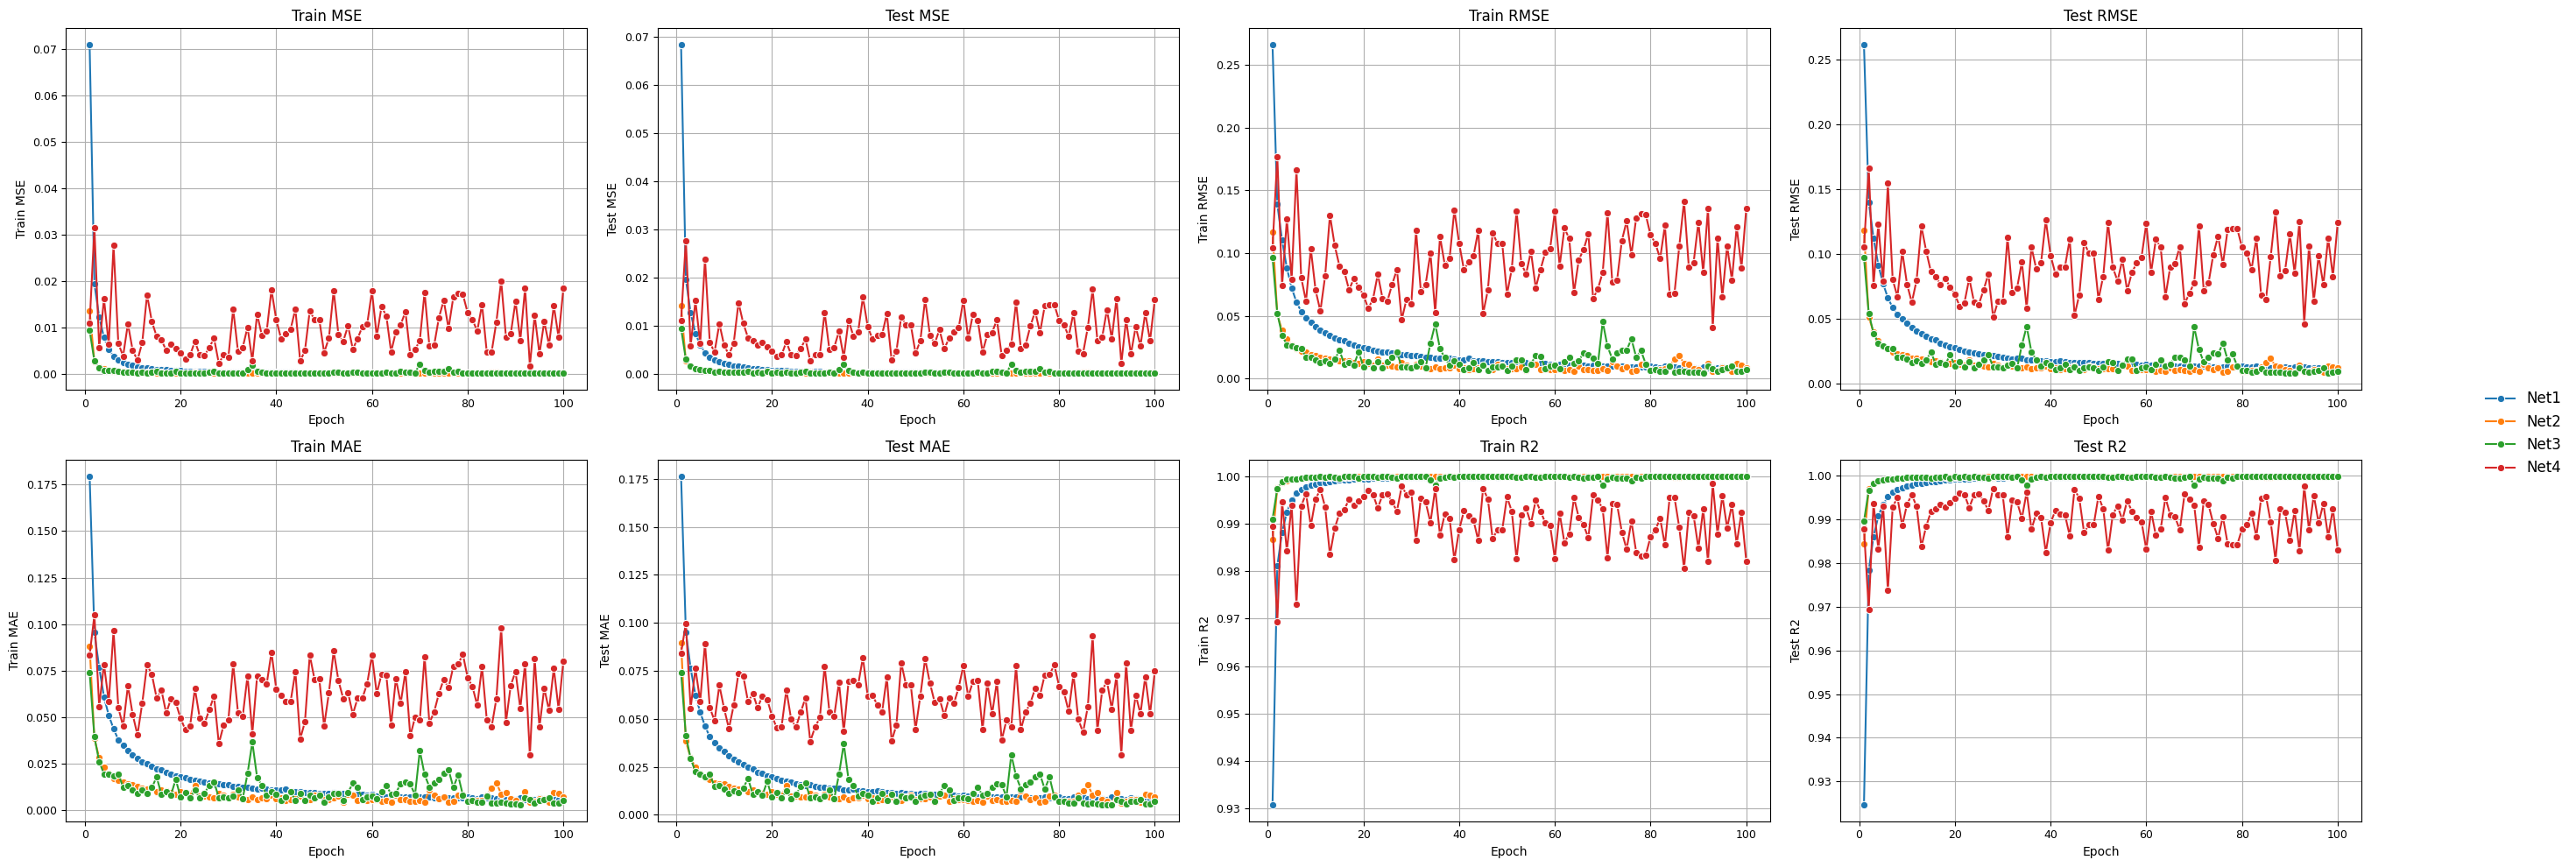

In [24]:
train_figures = {}

metrics_to_plot = ["Train MSE", "Test MSE", "Train RMSE", "Test RMSE", 
                   "Train MAE", "Test MAE", "Train R2", "Test R2"]

n_metrics = len(metrics_to_plot)
ncols = 4
nrows = (n_metrics + ncols - 1) // ncols  

fig, axes = plt.subplots(nrows, ncols, figsize=(28, 10), sharey=False)
axes = axes.flatten()

handles, labels = None, None

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    sns.lineplot(data=nn_metrics_df, x="Epoch", y=metric, hue="Model", marker='o', ax=ax)
    ax.set_title(metric, fontsize=12)
    ax.set_xlabel("Epoch", fontsize=10)
    ax.set_ylabel(metric, fontsize=10)
    ax.grid(True)
    ax.tick_params(labelsize=9)

    if handles is None and ax.get_legend():
        handles, labels = ax.get_legend_handles_labels()

    if ax.get_legend():
        ax.get_legend().remove()

for j in range(n_metrics, len(axes)):
    fig.delaxes(axes[j])
    
if handles and labels:
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.01, 0.5),
               fontsize="large", frameon=False)

plt.tight_layout(rect=[0, 0, 0.97, 1])  
train_figures["Train_Metrics_Nets"] = fig
plt.show()
plt.close()

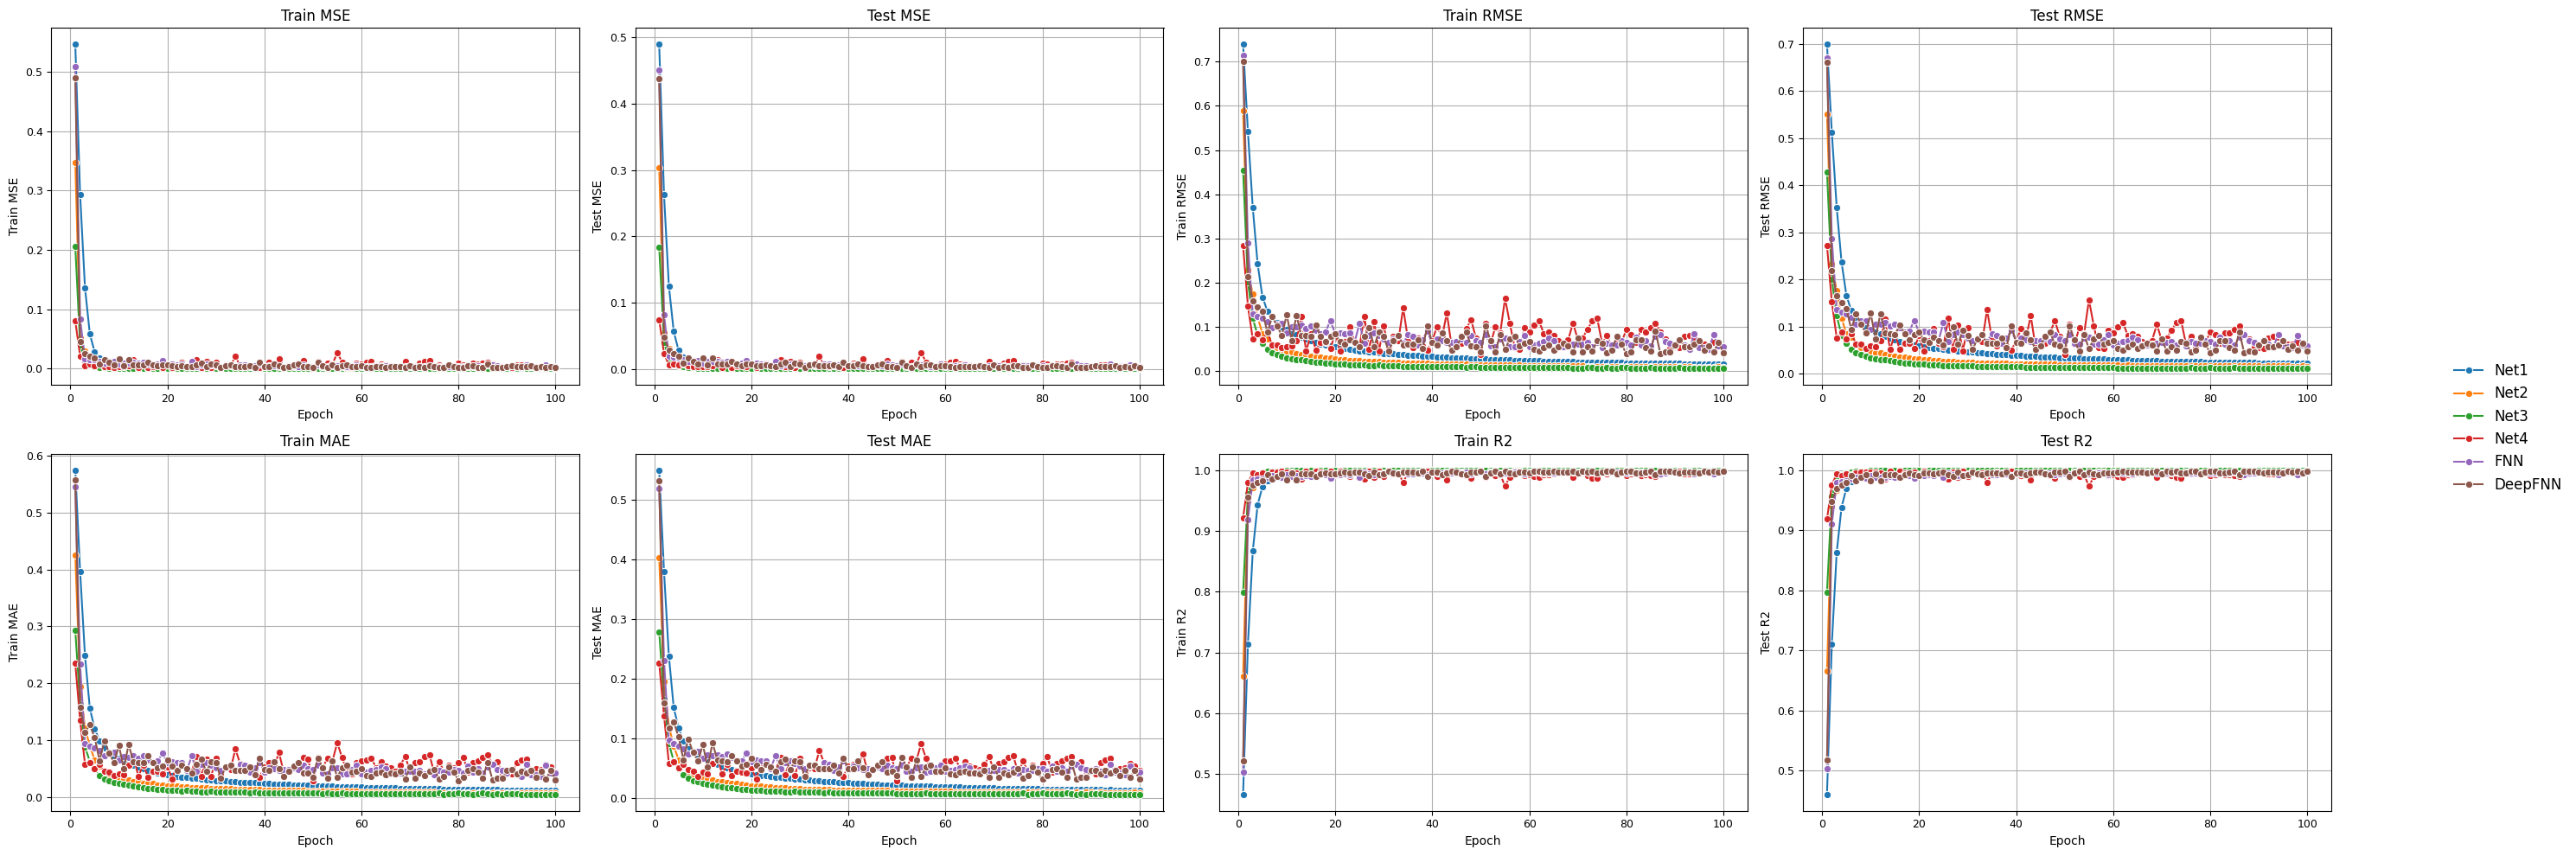

In [25]:
train_figures_tabular = {}

n_metrics = len(metrics_to_plot)
ncols = 4
nrows = (n_metrics + ncols - 1) // ncols  

fig, axes = plt.subplots(nrows, ncols, figsize=(28, 10), sharey=False)
axes = axes.flatten()

handles, labels = None, None

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    sns.lineplot(data=nn_metrics_df_tabular, x="Epoch", y=metric, hue="Model", marker='o', ax=ax)
    ax.set_title(metric, fontsize=12)
    ax.set_xlabel("Epoch", fontsize=10)
    ax.set_ylabel(metric, fontsize=10)
    ax.grid(True)
    ax.tick_params(labelsize=9)

    if handles is None and ax.get_legend():
        handles, labels = ax.get_legend_handles_labels()

    if ax.get_legend():
        ax.get_legend().remove()

for j in range(n_metrics, len(axes)):
    fig.delaxes(axes[j])
    
if handles and labels:
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.01, 0.5),
               fontsize="large", frameon=False)

plt.tight_layout(rect=[0, 0, 0.97, 1])  
train_figures_tabular["Train_Metrics_Tabular"] = fig
plt.show()
plt.close()

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X.values,         
    y.values,        
    test_size=0.2,
    shuffle=False
)

scaler_X = StandardScaler().fit(X_train)
X_train_scaled = scaler_X.transform(X_train)
X_test_scaled  = scaler_X.transform(X_test)

y_mean, y_std    = y_train.mean(), y_train.std()
y_train_norm     = (y_train - y_mean) / y_std
y_test_norm      = (y_test  - y_mean) / y_std

def create_sequence_data(X_arr, y_arr, seq_len=5):
    Xs, ys = [], []
    for i in range(len(X_arr) - seq_len):
        Xs.append(X_arr[i : i + seq_len])
        ys.append(y_arr[i + seq_len])
    return np.stack(Xs), np.stack(ys)

seq_len = 5
X_train_seq, y_train_seq = create_sequence_data(X_train_scaled, y_train_norm, seq_len)
X_test_seq,  y_test_seq  = create_sequence_data(X_test_scaled,  y_test_norm,  seq_len)

X_train_seq_tensor = torch.tensor(X_train_seq, dtype=torch.float32)  
y_train_seq_tensor = torch.tensor(y_train_seq, dtype=torch.float32).view(-1, 1)
X_test_seq_tensor  = torch.tensor(X_test_seq,  dtype=torch.float32)
y_test_seq_tensor  = torch.tensor(y_test_seq,  dtype=torch.float32).view(-1, 1)

train_loader_seq = DataLoader(
    TensorDataset(X_train_seq_tensor, y_train_seq_tensor),
    batch_size=64, shuffle=True
)
test_loader_seq  = DataLoader(
    TensorDataset(X_test_seq_tensor,  y_test_seq_tensor),
    batch_size=64, shuffle=False
)

In [27]:
in_channels = X_train_seq_tensor.shape[2]  

ts_nets = {
    "TCN":     TCN(in_channels, num_channels=[64,64]),
    "CNN1D":   CNN1D(in_channels, num_filters=32, num_layers=2, kernel_size=3, dropout=0.2),
    "GRUNet":  GRUNet(in_channels),
    "RNNNet":  RNNNet(in_channels),
    "CNNLSTM": CNNLSTM(in_channels),
    "BiLSTMNet":  BiLSTMNet(in_channels),
    "DeepLSTMNet":DeepLSTMNet(in_channels),
    "CNNBiLSTM":  CNNBiLSTM(in_channels),
    "GRUCNN":     GRUCNN(in_channels),
    "TCNLSTM":    TCNLSTM(in_channels),
    "Seq2SeqLSTM":Seq2SeqLSTM(in_channels),
}

In [28]:
results_ts = []
for name, net in ts_nets.items():
    results_ts += train_ts_model(
        name,
        net,
        train_loader_seq,       
        X_train_seq_tensor,     
        y_train_seq_tensor,     
        X_test_seq_tensor,      
        y_test_seq_tensor,      
        epochs=100,
        lr=1e-3
    )

nn_metrics_ts_df = pd.DataFrame(results_ts)

Training TCN:   1%|▉                                                                                        | 1/100 [00:03<05:00,  3.04s/it]


Model: TCN | Epoch: 1/100
Train: MSE: 0.0449, RMSE: 0.2120, MAE: 0.1323, R2: 0.9551
Test:  MSE: 0.1457, RMSE: 0.3817, MAE: 0.3401, R2: 0.9404


Training TCN:  10%|████████▊                                                                               | 10/100 [00:36<05:58,  3.98s/it]


Model: TCN | Epoch: 10/100
Train: MSE: 0.0179, RMSE: 0.1336, MAE: 0.0772, R2: 0.9822
Test:  MSE: 0.1160, RMSE: 0.3406, MAE: 0.2839, R2: 0.9525


Training TCN:  20%|█████████████████▌                                                                      | 20/100 [01:09<04:14,  3.18s/it]


Model: TCN | Epoch: 20/100
Train: MSE: 0.0149, RMSE: 0.1220, MAE: 0.0697, R2: 0.9851
Test:  MSE: 0.0879, RMSE: 0.2965, MAE: 0.2471, R2: 0.9640


Training TCN:  30%|██████████████████████████▍                                                             | 30/100 [01:44<04:25,  3.79s/it]


Model: TCN | Epoch: 30/100
Train: MSE: 0.0151, RMSE: 0.1228, MAE: 0.0724, R2: 0.9849
Test:  MSE: 0.0902, RMSE: 0.3003, MAE: 0.2501, R2: 0.9631


Training TCN:  40%|███████████████████████████████████▏                                                    | 40/100 [02:26<05:04,  5.07s/it]


Model: TCN | Epoch: 40/100
Train: MSE: 0.0104, RMSE: 0.1021, MAE: 0.0560, R2: 0.9896
Test:  MSE: 0.0720, RMSE: 0.2684, MAE: 0.2163, R2: 0.9705


Training TCN:  50%|████████████████████████████████████████████                                            | 50/100 [03:35<05:10,  6.22s/it]


Model: TCN | Epoch: 50/100
Train: MSE: 0.0108, RMSE: 0.1039, MAE: 0.0588, R2: 0.9892
Test:  MSE: 0.0675, RMSE: 0.2599, MAE: 0.2142, R2: 0.9724


Training TCN:  60%|████████████████████████████████████████████████████▊                                   | 60/100 [04:14<02:29,  3.74s/it]


Model: TCN | Epoch: 60/100
Train: MSE: 0.0101, RMSE: 0.1007, MAE: 0.0571, R2: 0.9899
Test:  MSE: 0.1230, RMSE: 0.3507, MAE: 0.2611, R2: 0.9497


Training TCN:  70%|█████████████████████████████████████████████████████████████▌                          | 70/100 [04:48<01:41,  3.37s/it]


Model: TCN | Epoch: 70/100
Train: MSE: 0.0099, RMSE: 0.0993, MAE: 0.0593, R2: 0.9902
Test:  MSE: 0.1200, RMSE: 0.3464, MAE: 0.2680, R2: 0.9509


Training TCN:  80%|██████████████████████████████████████████████████████████████████████▍                 | 80/100 [05:22<01:08,  3.41s/it]


Model: TCN | Epoch: 80/100
Train: MSE: 0.0094, RMSE: 0.0969, MAE: 0.0597, R2: 0.9906
Test:  MSE: 0.1031, RMSE: 0.3211, MAE: 0.2455, R2: 0.9578


Training TCN:  90%|███████████████████████████████████████████████████████████████████████████████▏        | 90/100 [05:56<00:34,  3.43s/it]


Model: TCN | Epoch: 90/100
Train: MSE: 0.0074, RMSE: 0.0860, MAE: 0.0496, R2: 0.9926
Test:  MSE: 0.1424, RMSE: 0.3773, MAE: 0.2730, R2: 0.9418


Training TCN: 100%|███████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:31<00:00,  3.91s/it]



Model: TCN | Epoch: 100/100
Train: MSE: 0.0062, RMSE: 0.0784, MAE: 0.0469, R2: 0.9939
Test:  MSE: 0.0851, RMSE: 0.2917, MAE: 0.2379, R2: 0.9652


Training CNN1D:   1%|▊                                                                                      | 1/100 [00:00<00:41,  2.38it/s]


Model: CNN1D | Epoch: 1/100
Train: MSE: 0.2947, RMSE: 0.5428, MAE: 0.2904, R2: 0.7057
Test:  MSE: 2.2325, RMSE: 1.4941, MAE: 1.3566, R2: 0.0867


Training CNN1D:  10%|████████▌                                                                             | 10/100 [00:04<00:43,  2.07it/s]


Model: CNN1D | Epoch: 10/100
Train: MSE: 0.0301, RMSE: 0.1735, MAE: 0.0924, R2: 0.9699
Test:  MSE: 0.1455, RMSE: 0.3815, MAE: 0.2511, R2: 0.9405


Training CNN1D:  20%|█████████████████▏                                                                    | 20/100 [00:08<00:33,  2.36it/s]


Model: CNN1D | Epoch: 20/100
Train: MSE: 0.0236, RMSE: 0.1535, MAE: 0.0810, R2: 0.9765
Test:  MSE: 0.0797, RMSE: 0.2823, MAE: 0.2049, R2: 0.9674


Training CNN1D:  30%|█████████████████████████▊                                                            | 30/100 [00:12<00:28,  2.44it/s]


Model: CNN1D | Epoch: 30/100
Train: MSE: 0.0212, RMSE: 0.1455, MAE: 0.0768, R2: 0.9789
Test:  MSE: 0.0691, RMSE: 0.2630, MAE: 0.1864, R2: 0.9717


Training CNN1D:  40%|██████████████████████████████████▍                                                   | 40/100 [00:16<00:24,  2.45it/s]


Model: CNN1D | Epoch: 40/100
Train: MSE: 0.0190, RMSE: 0.1379, MAE: 0.0763, R2: 0.9810
Test:  MSE: 0.0568, RMSE: 0.2383, MAE: 0.1717, R2: 0.9768


Training CNN1D:  50%|███████████████████████████████████████████                                           | 50/100 [00:20<00:20,  2.49it/s]


Model: CNN1D | Epoch: 50/100
Train: MSE: 0.0175, RMSE: 0.1321, MAE: 0.0703, R2: 0.9826
Test:  MSE: 0.0704, RMSE: 0.2653, MAE: 0.1826, R2: 0.9712


Training CNN1D:  60%|███████████████████████████████████████████████████▌                                  | 60/100 [00:25<00:17,  2.24it/s]


Model: CNN1D | Epoch: 60/100
Train: MSE: 0.0155, RMSE: 0.1244, MAE: 0.0651, R2: 0.9845
Test:  MSE: 0.0602, RMSE: 0.2454, MAE: 0.1650, R2: 0.9754


Training CNN1D:  70%|████████████████████████████████████████████████████████████▏                         | 70/100 [00:29<00:12,  2.43it/s]


Model: CNN1D | Epoch: 70/100
Train: MSE: 0.0175, RMSE: 0.1324, MAE: 0.0774, R2: 0.9825
Test:  MSE: 0.0747, RMSE: 0.2732, MAE: 0.1822, R2: 0.9695


Training CNN1D:  80%|████████████████████████████████████████████████████████████████████▊                 | 80/100 [00:33<00:08,  2.38it/s]


Model: CNN1D | Epoch: 80/100
Train: MSE: 0.0151, RMSE: 0.1227, MAE: 0.0697, R2: 0.9850
Test:  MSE: 0.0489, RMSE: 0.2212, MAE: 0.1452, R2: 0.9800


Training CNN1D:  90%|█████████████████████████████████████████████████████████████████████████████▍        | 90/100 [00:37<00:04,  2.39it/s]


Model: CNN1D | Epoch: 90/100
Train: MSE: 0.0163, RMSE: 0.1276, MAE: 0.0697, R2: 0.9837
Test:  MSE: 0.0767, RMSE: 0.2769, MAE: 0.1911, R2: 0.9686


Training CNN1D: 100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]



Model: CNN1D | Epoch: 100/100
Train: MSE: 0.0128, RMSE: 0.1132, MAE: 0.0616, R2: 0.9872
Test:  MSE: 0.0556, RMSE: 0.2357, MAE: 0.1586, R2: 0.9773


Training GRUNet:   1%|▊                                                                                     | 1/100 [00:00<00:33,  2.96it/s]


Model: GRUNet | Epoch: 1/100
Train: MSE: 0.2638, RMSE: 0.5136, MAE: 0.2843, R2: 0.7366
Test:  MSE: 1.8952, RMSE: 1.3767, MAE: 1.2487, R2: 0.2246


Training GRUNet:  10%|████████▌                                                                            | 10/100 [00:03<00:35,  2.54it/s]


Model: GRUNet | Epoch: 10/100
Train: MSE: 0.0268, RMSE: 0.1638, MAE: 0.0874, R2: 0.9732
Test:  MSE: 0.1446, RMSE: 0.3803, MAE: 0.2872, R2: 0.9408


Training GRUNet:  20%|█████████████████                                                                    | 20/100 [00:07<00:26,  2.99it/s]


Model: GRUNet | Epoch: 20/100
Train: MSE: 0.0222, RMSE: 0.1492, MAE: 0.0796, R2: 0.9778
Test:  MSE: 0.0830, RMSE: 0.2882, MAE: 0.2119, R2: 0.9660


Training GRUNet:  30%|█████████████████████████▌                                                           | 30/100 [00:11<00:23,  3.02it/s]


Model: GRUNet | Epoch: 30/100
Train: MSE: 0.0177, RMSE: 0.1329, MAE: 0.0692, R2: 0.9824
Test:  MSE: 0.0314, RMSE: 0.1773, MAE: 0.1252, R2: 0.9871


Training GRUNet:  40%|██████████████████████████████████                                                   | 40/100 [00:14<00:20,  2.96it/s]


Model: GRUNet | Epoch: 40/100
Train: MSE: 0.0148, RMSE: 0.1216, MAE: 0.0676, R2: 0.9852
Test:  MSE: 0.0629, RMSE: 0.2508, MAE: 0.1728, R2: 0.9743


Training GRUNet:  50%|██████████████████████████████████████████▌                                          | 50/100 [00:18<00:19,  2.60it/s]


Model: GRUNet | Epoch: 50/100
Train: MSE: 0.0122, RMSE: 0.1105, MAE: 0.0613, R2: 0.9878
Test:  MSE: 0.0600, RMSE: 0.2449, MAE: 0.1735, R2: 0.9755


Training GRUNet:  60%|███████████████████████████████████████████████████                                  | 60/100 [00:21<00:16,  2.47it/s]


Model: GRUNet | Epoch: 60/100
Train: MSE: 0.0103, RMSE: 0.1015, MAE: 0.0571, R2: 0.9897
Test:  MSE: 0.0516, RMSE: 0.2272, MAE: 0.1683, R2: 0.9789


Training GRUNet:  70%|███████████████████████████████████████████████████████████▍                         | 70/100 [00:25<00:09,  3.04it/s]


Model: GRUNet | Epoch: 70/100
Train: MSE: 0.0090, RMSE: 0.0950, MAE: 0.0530, R2: 0.9910
Test:  MSE: 0.0565, RMSE: 0.2378, MAE: 0.1706, R2: 0.9769


Training GRUNet:  80%|████████████████████████████████████████████████████████████████████                 | 80/100 [00:29<00:06,  2.98it/s]


Model: GRUNet | Epoch: 80/100
Train: MSE: 0.0090, RMSE: 0.0950, MAE: 0.0549, R2: 0.9910
Test:  MSE: 0.0568, RMSE: 0.2383, MAE: 0.1731, R2: 0.9768


Training GRUNet:  90%|████████████████████████████████████████████████████████████████████████████▌        | 90/100 [00:32<00:03,  2.88it/s]


Model: GRUNet | Epoch: 90/100
Train: MSE: 0.0076, RMSE: 0.0873, MAE: 0.0495, R2: 0.9924
Test:  MSE: 0.0539, RMSE: 0.2321, MAE: 0.1709, R2: 0.9780


Training GRUNet: 100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.76it/s]



Model: GRUNet | Epoch: 100/100
Train: MSE: 0.0057, RMSE: 0.0754, MAE: 0.0440, R2: 0.9943
Test:  MSE: 0.0598, RMSE: 0.2445, MAE: 0.1833, R2: 0.9755


Training RNNNet:   1%|▊                                                                                     | 1/100 [00:00<00:15,  6.56it/s]


Model: RNNNet | Epoch: 1/100
Train: MSE: 0.0382, RMSE: 0.1954, MAE: 0.1178, R2: 0.9619
Test:  MSE: 0.0476, RMSE: 0.2182, MAE: 0.1555, R2: 0.9805


Training RNNNet:  11%|█████████▎                                                                           | 11/100 [00:01<00:14,  6.27it/s]


Model: RNNNet | Epoch: 10/100
Train: MSE: 0.0183, RMSE: 0.1354, MAE: 0.0795, R2: 0.9817
Test:  MSE: 0.1410, RMSE: 0.3755, MAE: 0.2716, R2: 0.9423


Training RNNNet:  20%|█████████████████                                                                    | 20/100 [00:03<00:16,  4.76it/s]


Model: RNNNet | Epoch: 20/100
Train: MSE: 0.0158, RMSE: 0.1256, MAE: 0.0710, R2: 0.9842
Test:  MSE: 0.0840, RMSE: 0.2898, MAE: 0.1995, R2: 0.9656


Training RNNNet:  31%|██████████████████████████▎                                                          | 31/100 [00:05<00:11,  6.27it/s]


Model: RNNNet | Epoch: 30/100
Train: MSE: 0.0131, RMSE: 0.1146, MAE: 0.0646, R2: 0.9869
Test:  MSE: 0.1017, RMSE: 0.3188, MAE: 0.2331, R2: 0.9584


Training RNNNet:  41%|██████████████████████████████████▊                                                  | 41/100 [00:06<00:09,  6.33it/s]


Model: RNNNet | Epoch: 40/100
Train: MSE: 0.0140, RMSE: 0.1181, MAE: 0.0721, R2: 0.9861
Test:  MSE: 0.1458, RMSE: 0.3818, MAE: 0.2853, R2: 0.9404


Training RNNNet:  51%|███████████████████████████████████████████▎                                         | 51/100 [00:08<00:08,  5.85it/s]


Model: RNNNet | Epoch: 50/100
Train: MSE: 0.0117, RMSE: 0.1081, MAE: 0.0657, R2: 0.9883
Test:  MSE: 0.0946, RMSE: 0.3076, MAE: 0.2243, R2: 0.9613


Training RNNNet:  61%|███████████████████████████████████████████████████▊                                 | 61/100 [00:10<00:06,  5.78it/s]


Model: RNNNet | Epoch: 60/100
Train: MSE: 0.0108, RMSE: 0.1039, MAE: 0.0645, R2: 0.9892
Test:  MSE: 0.1228, RMSE: 0.3504, MAE: 0.2424, R2: 0.9498


Training RNNNet:  71%|████████████████████████████████████████████████████████████▎                        | 71/100 [00:12<00:05,  4.86it/s]


Model: RNNNet | Epoch: 70/100
Train: MSE: 0.0082, RMSE: 0.0907, MAE: 0.0511, R2: 0.9918
Test:  MSE: 0.0947, RMSE: 0.3078, MAE: 0.2284, R2: 0.9612


Training RNNNet:  81%|████████████████████████████████████████████████████████████████████▊                | 81/100 [00:14<00:03,  6.01it/s]


Model: RNNNet | Epoch: 80/100
Train: MSE: 0.0080, RMSE: 0.0896, MAE: 0.0520, R2: 0.9920
Test:  MSE: 0.1450, RMSE: 0.3807, MAE: 0.2783, R2: 0.9407


Training RNNNet:  90%|████████████████████████████████████████████████████████████████████████████▌        | 90/100 [00:15<00:01,  5.81it/s]


Model: RNNNet | Epoch: 90/100
Train: MSE: 0.0093, RMSE: 0.0963, MAE: 0.0643, R2: 0.9907
Test:  MSE: 0.1726, RMSE: 0.4155, MAE: 0.3310, R2: 0.9294


Training RNNNet: 100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.65it/s]



Model: RNNNet | Epoch: 100/100
Train: MSE: 0.0057, RMSE: 0.0755, MAE: 0.0456, R2: 0.9943
Test:  MSE: 0.1304, RMSE: 0.3612, MAE: 0.2856, R2: 0.9466


Training CNNLSTM:   1%|▊                                                                                    | 1/100 [00:05<08:48,  5.34s/it]


Model: CNNLSTM | Epoch: 1/100
Train: MSE: 0.4308, RMSE: 0.6564, MAE: 0.3648, R2: 0.5697
Test:  MSE: 2.9752, RMSE: 1.7249, MAE: 1.5299, R2: -0.2172


Training CNNLSTM:  10%|████████▍                                                                           | 10/100 [00:56<09:01,  6.02s/it]


Model: CNNLSTM | Epoch: 10/100
Train: MSE: 0.0505, RMSE: 0.2247, MAE: 0.1262, R2: 0.9496
Test:  MSE: 0.0608, RMSE: 0.2465, MAE: 0.1620, R2: 0.9751


Training CNNLSTM:  20%|████████████████▊                                                                   | 20/100 [01:59<08:16,  6.20s/it]


Model: CNNLSTM | Epoch: 20/100
Train: MSE: 0.0326, RMSE: 0.1806, MAE: 0.0977, R2: 0.9674
Test:  MSE: 0.0382, RMSE: 0.1954, MAE: 0.1459, R2: 0.9844


Training CNNLSTM:  30%|█████████████████████████▏                                                          | 30/100 [03:01<07:04,  6.06s/it]


Model: CNNLSTM | Epoch: 30/100
Train: MSE: 0.0299, RMSE: 0.1729, MAE: 0.0916, R2: 0.9701
Test:  MSE: 0.0428, RMSE: 0.2069, MAE: 0.1606, R2: 0.9825


Training CNNLSTM:  40%|█████████████████████████████████▌                                                  | 40/100 [04:00<06:05,  6.09s/it]


Model: CNNLSTM | Epoch: 40/100
Train: MSE: 0.0248, RMSE: 0.1574, MAE: 0.0951, R2: 0.9752
Test:  MSE: 0.0673, RMSE: 0.2594, MAE: 0.1868, R2: 0.9725


Training CNNLSTM:  50%|██████████████████████████████████████████                                          | 50/100 [04:59<04:58,  5.97s/it]


Model: CNNLSTM | Epoch: 50/100
Train: MSE: 0.0268, RMSE: 0.1638, MAE: 0.0915, R2: 0.9732
Test:  MSE: 0.0581, RMSE: 0.2409, MAE: 0.1822, R2: 0.9762


Training CNNLSTM:  60%|██████████████████████████████████████████████████▍                                 | 60/100 [05:59<04:02,  6.07s/it]


Model: CNNLSTM | Epoch: 60/100
Train: MSE: 0.0199, RMSE: 0.1412, MAE: 0.0859, R2: 0.9801
Test:  MSE: 0.0297, RMSE: 0.1724, MAE: 0.1366, R2: 0.9878


Training CNNLSTM:  70%|██████████████████████████████████████████████████████████▊                         | 70/100 [07:00<03:00,  6.03s/it]


Model: CNNLSTM | Epoch: 70/100
Train: MSE: 0.0167, RMSE: 0.1294, MAE: 0.0707, R2: 0.9833
Test:  MSE: 0.0315, RMSE: 0.1776, MAE: 0.1390, R2: 0.9871


Training CNNLSTM:  80%|███████████████████████████████████████████████████████████████████▏                | 80/100 [08:04<02:10,  6.54s/it]


Model: CNNLSTM | Epoch: 80/100
Train: MSE: 0.0162, RMSE: 0.1272, MAE: 0.0718, R2: 0.9838
Test:  MSE: 0.0446, RMSE: 0.2112, MAE: 0.1702, R2: 0.9817


Training CNNLSTM:  90%|███████████████████████████████████████████████████████████████████████████▌        | 90/100 [09:14<01:03,  6.32s/it]


Model: CNNLSTM | Epoch: 90/100
Train: MSE: 0.0163, RMSE: 0.1277, MAE: 0.0721, R2: 0.9837
Test:  MSE: 0.0441, RMSE: 0.2100, MAE: 0.1625, R2: 0.9820


Training CNNLSTM: 100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [10:13<00:00,  6.14s/it]



Model: CNNLSTM | Epoch: 100/100
Train: MSE: 0.0137, RMSE: 0.1171, MAE: 0.0678, R2: 0.9863
Test:  MSE: 0.0665, RMSE: 0.2578, MAE: 0.2152, R2: 0.9728


Training BiLSTMNet:   1%|▊                                                                                  | 1/100 [00:00<01:33,  1.06it/s]


Model: BiLSTMNet | Epoch: 1/100
Train: MSE: 0.2753, RMSE: 0.5247, MAE: 0.2918, R2: 0.7250
Test:  MSE: 2.0472, RMSE: 1.4308, MAE: 1.2416, R2: 0.1624


Training BiLSTMNet:  10%|████████▏                                                                         | 10/100 [00:10<01:39,  1.10s/it]


Model: BiLSTMNet | Epoch: 10/100
Train: MSE: 0.0278, RMSE: 0.1666, MAE: 0.0952, R2: 0.9723
Test:  MSE: 0.3285, RMSE: 0.5731, MAE: 0.3592, R2: 0.8656


Training BiLSTMNet:  20%|████████████████▍                                                                 | 20/100 [00:20<01:29,  1.11s/it]


Model: BiLSTMNet | Epoch: 20/100
Train: MSE: 0.0227, RMSE: 0.1507, MAE: 0.0830, R2: 0.9773
Test:  MSE: 0.2801, RMSE: 0.5293, MAE: 0.3365, R2: 0.8854


Training BiLSTMNet:  30%|████████████████████████▌                                                         | 30/100 [00:29<01:06,  1.05it/s]


Model: BiLSTMNet | Epoch: 30/100
Train: MSE: 0.0228, RMSE: 0.1509, MAE: 0.0884, R2: 0.9773
Test:  MSE: 0.2676, RMSE: 0.5173, MAE: 0.3322, R2: 0.8905


Training BiLSTMNet:  40%|████████████████████████████████▊                                                 | 40/100 [00:38<00:51,  1.16it/s]


Model: BiLSTMNet | Epoch: 40/100
Train: MSE: 0.0212, RMSE: 0.1457, MAE: 0.0840, R2: 0.9788
Test:  MSE: 0.2506, RMSE: 0.5006, MAE: 0.3188, R2: 0.8975


Training BiLSTMNet:  50%|█████████████████████████████████████████                                         | 50/100 [00:46<00:41,  1.22it/s]


Model: BiLSTMNet | Epoch: 50/100
Train: MSE: 0.0146, RMSE: 0.1207, MAE: 0.0697, R2: 0.9855
Test:  MSE: 0.2309, RMSE: 0.4805, MAE: 0.3057, R2: 0.9055


Training BiLSTMNet:  60%|█████████████████████████████████████████████████▏                                | 60/100 [00:54<00:32,  1.22it/s]


Model: BiLSTMNet | Epoch: 60/100
Train: MSE: 0.0148, RMSE: 0.1216, MAE: 0.0645, R2: 0.9852
Test:  MSE: 0.1990, RMSE: 0.4461, MAE: 0.2800, R2: 0.9186


Training BiLSTMNet:  70%|█████████████████████████████████████████████████████████▍                        | 70/100 [01:02<00:24,  1.25it/s]


Model: BiLSTMNet | Epoch: 70/100
Train: MSE: 0.0115, RMSE: 0.1074, MAE: 0.0614, R2: 0.9885
Test:  MSE: 0.2051, RMSE: 0.4528, MAE: 0.2842, R2: 0.9161


Training BiLSTMNet:  80%|█████████████████████████████████████████████████████████████████▌                | 80/100 [01:11<00:16,  1.23it/s]


Model: BiLSTMNet | Epoch: 80/100
Train: MSE: 0.0106, RMSE: 0.1028, MAE: 0.0590, R2: 0.9895
Test:  MSE: 0.1978, RMSE: 0.4447, MAE: 0.2688, R2: 0.9191


Training BiLSTMNet:  90%|█████████████████████████████████████████████████████████████████████████▊        | 90/100 [01:19<00:08,  1.20it/s]


Model: BiLSTMNet | Epoch: 90/100
Train: MSE: 0.0105, RMSE: 0.1023, MAE: 0.0591, R2: 0.9896
Test:  MSE: 0.2529, RMSE: 0.5029, MAE: 0.3103, R2: 0.8965


Training BiLSTMNet: 100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.14it/s]



Model: BiLSTMNet | Epoch: 100/100
Train: MSE: 0.0102, RMSE: 0.1011, MAE: 0.0624, R2: 0.9898
Test:  MSE: 0.2442, RMSE: 0.4942, MAE: 0.3086, R2: 0.9001


Training DeepLSTMNet:   1%|▊                                                                                | 1/100 [00:01<02:29,  1.51s/it]


Model: DeepLSTMNet | Epoch: 1/100
Train: MSE: 0.1252, RMSE: 0.3538, MAE: 0.1811, R2: 0.8750
Test:  MSE: 0.2000, RMSE: 0.4472, MAE: 0.3037, R2: 0.9182


Training DeepLSTMNet:  10%|████████                                                                        | 10/100 [00:15<02:16,  1.52s/it]


Model: DeepLSTMNet | Epoch: 10/100
Train: MSE: 0.0285, RMSE: 0.1688, MAE: 0.0888, R2: 0.9715
Test:  MSE: 0.1352, RMSE: 0.3678, MAE: 0.2473, R2: 0.9447


Training DeepLSTMNet:  20%|████████████████                                                                | 20/100 [00:32<02:16,  1.70s/it]


Model: DeepLSTMNet | Epoch: 20/100
Train: MSE: 0.0252, RMSE: 0.1589, MAE: 0.0863, R2: 0.9748
Test:  MSE: 0.0781, RMSE: 0.2794, MAE: 0.1834, R2: 0.9681


Training DeepLSTMNet:  30%|████████████████████████                                                        | 30/100 [00:48<01:53,  1.62s/it]


Model: DeepLSTMNet | Epoch: 30/100
Train: MSE: 0.0242, RMSE: 0.1556, MAE: 0.0876, R2: 0.9758
Test:  MSE: 0.0214, RMSE: 0.1463, MAE: 0.1027, R2: 0.9912


Training DeepLSTMNet:  40%|████████████████████████████████                                                | 40/100 [01:06<01:53,  1.89s/it]


Model: DeepLSTMNet | Epoch: 40/100
Train: MSE: 0.0181, RMSE: 0.1344, MAE: 0.0734, R2: 0.9819
Test:  MSE: 0.0382, RMSE: 0.1955, MAE: 0.1363, R2: 0.9844


Training DeepLSTMNet:  50%|████████████████████████████████████████                                        | 50/100 [01:23<01:30,  1.81s/it]


Model: DeepLSTMNet | Epoch: 50/100
Train: MSE: 0.0178, RMSE: 0.1335, MAE: 0.0794, R2: 0.9822
Test:  MSE: 0.0353, RMSE: 0.1879, MAE: 0.1192, R2: 0.9856


Training DeepLSTMNet:  60%|████████████████████████████████████████████████                                | 60/100 [01:40<01:05,  1.65s/it]


Model: DeepLSTMNet | Epoch: 60/100
Train: MSE: 0.0176, RMSE: 0.1325, MAE: 0.0739, R2: 0.9825
Test:  MSE: 0.0769, RMSE: 0.2773, MAE: 0.1755, R2: 0.9686


Training DeepLSTMNet:  70%|████████████████████████████████████████████████████████                        | 70/100 [01:57<00:49,  1.65s/it]


Model: DeepLSTMNet | Epoch: 70/100
Train: MSE: 0.0141, RMSE: 0.1188, MAE: 0.0664, R2: 0.9859
Test:  MSE: 0.0714, RMSE: 0.2673, MAE: 0.1664, R2: 0.9708


Training DeepLSTMNet:  80%|████████████████████████████████████████████████████████████████                | 80/100 [02:14<00:34,  1.72s/it]


Model: DeepLSTMNet | Epoch: 80/100
Train: MSE: 0.0159, RMSE: 0.1260, MAE: 0.0723, R2: 0.9841
Test:  MSE: 0.0352, RMSE: 0.1876, MAE: 0.1318, R2: 0.9856


Training DeepLSTMNet:  90%|████████████████████████████████████████████████████████████████████████        | 90/100 [02:32<00:17,  1.75s/it]


Model: DeepLSTMNet | Epoch: 90/100
Train: MSE: 0.0106, RMSE: 0.1031, MAE: 0.0599, R2: 0.9894
Test:  MSE: 0.0407, RMSE: 0.2017, MAE: 0.1446, R2: 0.9834


Training DeepLSTMNet: 100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [02:50<00:00,  1.70s/it]



Model: DeepLSTMNet | Epoch: 100/100
Train: MSE: 0.0090, RMSE: 0.0949, MAE: 0.0548, R2: 0.9910
Test:  MSE: 0.1275, RMSE: 0.3571, MAE: 0.2186, R2: 0.9478


Training CNNBiLSTM:   1%|▊                                                                                  | 1/100 [00:01<02:05,  1.27s/it]


Model: CNNBiLSTM | Epoch: 1/100
Train: MSE: 0.2176, RMSE: 0.4665, MAE: 0.2511, R2: 0.7827
Test:  MSE: 1.4951, RMSE: 1.2227, MAE: 1.0627, R2: 0.3883


Training CNNBiLSTM:  10%|████████▏                                                                         | 10/100 [00:12<01:45,  1.17s/it]


Model: CNNBiLSTM | Epoch: 10/100
Train: MSE: 0.0239, RMSE: 0.1544, MAE: 0.0823, R2: 0.9762
Test:  MSE: 0.0426, RMSE: 0.2063, MAE: 0.1514, R2: 0.9826


Training CNNBiLSTM:  20%|████████████████▍                                                                 | 20/100 [00:23<01:35,  1.20s/it]


Model: CNNBiLSTM | Epoch: 20/100
Train: MSE: 0.0279, RMSE: 0.1671, MAE: 0.0950, R2: 0.9721
Test:  MSE: 0.0199, RMSE: 0.1412, MAE: 0.1129, R2: 0.9918


Training CNNBiLSTM:  30%|████████████████████████▌                                                         | 30/100 [00:35<01:21,  1.17s/it]


Model: CNNBiLSTM | Epoch: 30/100
Train: MSE: 0.0165, RMSE: 0.1284, MAE: 0.0713, R2: 0.9835
Test:  MSE: 0.0409, RMSE: 0.2022, MAE: 0.1554, R2: 0.9833


Training CNNBiLSTM:  40%|████████████████████████████████▊                                                 | 40/100 [00:47<01:11,  1.20s/it]


Model: CNNBiLSTM | Epoch: 40/100
Train: MSE: 0.0167, RMSE: 0.1293, MAE: 0.0711, R2: 0.9833
Test:  MSE: 0.0222, RMSE: 0.1489, MAE: 0.1258, R2: 0.9909


Training CNNBiLSTM:  50%|█████████████████████████████████████████                                         | 50/100 [00:59<01:00,  1.20s/it]


Model: CNNBiLSTM | Epoch: 50/100
Train: MSE: 0.0139, RMSE: 0.1181, MAE: 0.0656, R2: 0.9861
Test:  MSE: 0.0414, RMSE: 0.2035, MAE: 0.1541, R2: 0.9831


Training CNNBiLSTM:  60%|█████████████████████████████████████████████████▏                                | 60/100 [01:11<00:49,  1.23s/it]


Model: CNNBiLSTM | Epoch: 60/100
Train: MSE: 0.0131, RMSE: 0.1146, MAE: 0.0639, R2: 0.9869
Test:  MSE: 0.0360, RMSE: 0.1897, MAE: 0.1524, R2: 0.9853


Training CNNBiLSTM:  70%|█████████████████████████████████████████████████████████▍                        | 70/100 [01:24<00:37,  1.25s/it]


Model: CNNBiLSTM | Epoch: 70/100
Train: MSE: 0.0123, RMSE: 0.1108, MAE: 0.0642, R2: 0.9878
Test:  MSE: 0.0489, RMSE: 0.2211, MAE: 0.1719, R2: 0.9800


Training CNNBiLSTM:  80%|█████████████████████████████████████████████████████████████████▌                | 80/100 [01:37<00:25,  1.30s/it]


Model: CNNBiLSTM | Epoch: 80/100
Train: MSE: 0.0110, RMSE: 0.1047, MAE: 0.0616, R2: 0.9890
Test:  MSE: 0.0620, RMSE: 0.2489, MAE: 0.1987, R2: 0.9746


Training CNNBiLSTM:  90%|█████████████████████████████████████████████████████████████████████████▊        | 90/100 [01:48<00:11,  1.10s/it]


Model: CNNBiLSTM | Epoch: 90/100
Train: MSE: 0.0106, RMSE: 0.1031, MAE: 0.0579, R2: 0.9894
Test:  MSE: 0.0465, RMSE: 0.2156, MAE: 0.1734, R2: 0.9810


Training CNNBiLSTM: 100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [02:00<00:00,  1.21s/it]



Model: CNNBiLSTM | Epoch: 100/100
Train: MSE: 0.0093, RMSE: 0.0964, MAE: 0.0546, R2: 0.9907
Test:  MSE: 0.0372, RMSE: 0.1928, MAE: 0.1561, R2: 0.9848


Training GRUCNN:   1%|▊                                                                                     | 1/100 [00:00<00:54,  1.83it/s]


Model: GRUCNN | Epoch: 1/100
Train: MSE: 0.2263, RMSE: 0.4757, MAE: 0.2688, R2: 0.7740
Test:  MSE: 1.6053, RMSE: 1.2670, MAE: 1.1313, R2: 0.3432


Training GRUCNN:  10%|████████▌                                                                            | 10/100 [00:05<00:50,  1.79it/s]


Model: GRUCNN | Epoch: 10/100
Train: MSE: 0.0283, RMSE: 0.1682, MAE: 0.0884, R2: 0.9717
Test:  MSE: 0.2557, RMSE: 0.5057, MAE: 0.3504, R2: 0.8954


Training GRUCNN:  20%|█████████████████                                                                    | 20/100 [00:11<00:47,  1.69it/s]


Model: GRUCNN | Epoch: 20/100
Train: MSE: 0.0238, RMSE: 0.1542, MAE: 0.0850, R2: 0.9762
Test:  MSE: 0.2029, RMSE: 0.4505, MAE: 0.2977, R2: 0.9170


Training GRUCNN:  30%|█████████████████████████▌                                                           | 30/100 [00:16<00:38,  1.80it/s]


Model: GRUCNN | Epoch: 30/100
Train: MSE: 0.0252, RMSE: 0.1588, MAE: 0.0931, R2: 0.9748
Test:  MSE: 0.2593, RMSE: 0.5092, MAE: 0.3182, R2: 0.8939


Training GRUCNN:  40%|██████████████████████████████████                                                   | 40/100 [00:22<00:33,  1.80it/s]


Model: GRUCNN | Epoch: 40/100
Train: MSE: 0.0223, RMSE: 0.1494, MAE: 0.0836, R2: 0.9777
Test:  MSE: 0.2165, RMSE: 0.4653, MAE: 0.2885, R2: 0.9114


Training GRUCNN:  50%|██████████████████████████████████████████▌                                          | 50/100 [00:28<00:30,  1.66it/s]


Model: GRUCNN | Epoch: 50/100
Train: MSE: 0.0187, RMSE: 0.1367, MAE: 0.0784, R2: 0.9813
Test:  MSE: 0.1951, RMSE: 0.4417, MAE: 0.3038, R2: 0.9202


Training GRUCNN:  60%|███████████████████████████████████████████████████                                  | 60/100 [00:34<00:22,  1.77it/s]


Model: GRUCNN | Epoch: 60/100
Train: MSE: 0.0192, RMSE: 0.1387, MAE: 0.0779, R2: 0.9808
Test:  MSE: 0.2063, RMSE: 0.4542, MAE: 0.3038, R2: 0.9156


Training GRUCNN:  70%|███████████████████████████████████████████████████████████▍                         | 70/100 [00:39<00:17,  1.76it/s]


Model: GRUCNN | Epoch: 70/100
Train: MSE: 0.0140, RMSE: 0.1182, MAE: 0.0659, R2: 0.9860
Test:  MSE: 0.1195, RMSE: 0.3457, MAE: 0.2388, R2: 0.9511


Training GRUCNN:  80%|████████████████████████████████████████████████████████████████████                 | 80/100 [00:45<00:10,  1.85it/s]


Model: GRUCNN | Epoch: 80/100
Train: MSE: 0.0137, RMSE: 0.1173, MAE: 0.0645, R2: 0.9863
Test:  MSE: 0.1920, RMSE: 0.4382, MAE: 0.3224, R2: 0.9215


Training GRUCNN:  90%|████████████████████████████████████████████████████████████████████████████▌        | 90/100 [00:50<00:05,  1.94it/s]


Model: GRUCNN | Epoch: 90/100
Train: MSE: 0.0110, RMSE: 0.1048, MAE: 0.0570, R2: 0.9890
Test:  MSE: 0.1209, RMSE: 0.3477, MAE: 0.2781, R2: 0.9505


Training GRUCNN: 100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.78it/s]



Model: GRUCNN | Epoch: 100/100
Train: MSE: 0.0107, RMSE: 0.1035, MAE: 0.0554, R2: 0.9893
Test:  MSE: 0.1593, RMSE: 0.3991, MAE: 0.3025, R2: 0.9348


Training TCNLSTM:   1%|▊                                                                                    | 1/100 [00:05<08:58,  5.44s/it]


Model: TCNLSTM | Epoch: 1/100
Train: MSE: 0.0407, RMSE: 0.2019, MAE: 0.1231, R2: 0.9593
Test:  MSE: 0.0455, RMSE: 0.2132, MAE: 0.1787, R2: 0.9814


Training TCNLSTM:  10%|████████▍                                                                           | 10/100 [00:51<07:35,  5.06s/it]


Model: TCNLSTM | Epoch: 10/100
Train: MSE: 0.0181, RMSE: 0.1347, MAE: 0.0791, R2: 0.9819
Test:  MSE: 0.0210, RMSE: 0.1450, MAE: 0.1297, R2: 0.9914


Training TCNLSTM:  20%|████████████████▊                                                                   | 20/100 [01:42<06:41,  5.02s/it]


Model: TCNLSTM | Epoch: 20/100
Train: MSE: 0.0146, RMSE: 0.1209, MAE: 0.0713, R2: 0.9854
Test:  MSE: 0.0301, RMSE: 0.1734, MAE: 0.1508, R2: 0.9877


Training TCNLSTM:  30%|█████████████████████████▏                                                          | 30/100 [02:33<05:55,  5.08s/it]


Model: TCNLSTM | Epoch: 30/100
Train: MSE: 0.0127, RMSE: 0.1127, MAE: 0.0639, R2: 0.9873
Test:  MSE: 0.0386, RMSE: 0.1964, MAE: 0.1637, R2: 0.9842


Training TCNLSTM:  40%|█████████████████████████████████▌                                                  | 40/100 [03:23<05:01,  5.02s/it]


Model: TCNLSTM | Epoch: 40/100
Train: MSE: 0.0101, RMSE: 0.1006, MAE: 0.0562, R2: 0.9899
Test:  MSE: 0.0377, RMSE: 0.1943, MAE: 0.1554, R2: 0.9846


Training TCNLSTM:  50%|██████████████████████████████████████████                                          | 50/100 [04:13<04:09,  4.99s/it]


Model: TCNLSTM | Epoch: 50/100
Train: MSE: 0.0097, RMSE: 0.0985, MAE: 0.0565, R2: 0.9903
Test:  MSE: 0.0340, RMSE: 0.1844, MAE: 0.1516, R2: 0.9861


Training TCNLSTM:  60%|██████████████████████████████████████████████████▍                                 | 60/100 [05:04<03:19,  5.00s/it]


Model: TCNLSTM | Epoch: 60/100
Train: MSE: 0.0077, RMSE: 0.0876, MAE: 0.0500, R2: 0.9923
Test:  MSE: 0.0362, RMSE: 0.1904, MAE: 0.1488, R2: 0.9852


Training TCNLSTM:  70%|██████████████████████████████████████████████████████████▊                         | 70/100 [05:55<02:30,  5.00s/it]


Model: TCNLSTM | Epoch: 70/100
Train: MSE: 0.0077, RMSE: 0.0880, MAE: 0.0521, R2: 0.9923
Test:  MSE: 0.0476, RMSE: 0.2182, MAE: 0.1759, R2: 0.9805


Training TCNLSTM:  80%|███████████████████████████████████████████████████████████████████▏                | 80/100 [06:45<01:32,  4.64s/it]


Model: TCNLSTM | Epoch: 80/100
Train: MSE: 0.0078, RMSE: 0.0882, MAE: 0.0539, R2: 0.9922
Test:  MSE: 0.0368, RMSE: 0.1919, MAE: 0.1493, R2: 0.9849


Training TCNLSTM:  90%|███████████████████████████████████████████████████████████████████████████▌        | 90/100 [07:32<00:48,  4.82s/it]


Model: TCNLSTM | Epoch: 90/100
Train: MSE: 0.0065, RMSE: 0.0808, MAE: 0.0456, R2: 0.9935
Test:  MSE: 0.0436, RMSE: 0.2088, MAE: 0.1672, R2: 0.9822


Training TCNLSTM: 100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [08:17<00:00,  4.98s/it]



Model: TCNLSTM | Epoch: 100/100
Train: MSE: 0.0057, RMSE: 0.0753, MAE: 0.0426, R2: 0.9943
Test:  MSE: 0.0429, RMSE: 0.2072, MAE: 0.1706, R2: 0.9824


Training Seq2SeqLSTM:   1%|▊                                                                                | 1/100 [00:00<00:49,  1.98it/s]


Model: Seq2SeqLSTM | Epoch: 1/100
Train: MSE: 0.2650, RMSE: 0.5148, MAE: 0.2703, R2: 0.7353
Test:  MSE: 2.0772, RMSE: 1.4413, MAE: 1.1579, R2: 0.1502


Training Seq2SeqLSTM:  10%|████████                                                                        | 10/100 [00:04<00:41,  2.19it/s]


Model: Seq2SeqLSTM | Epoch: 10/100
Train: MSE: 0.0290, RMSE: 0.1704, MAE: 0.0985, R2: 0.9710
Test:  MSE: 0.6252, RMSE: 0.7907, MAE: 0.4718, R2: 0.7442


Training Seq2SeqLSTM:  20%|████████████████                                                                | 20/100 [00:09<00:41,  1.95it/s]


Model: Seq2SeqLSTM | Epoch: 20/100
Train: MSE: 0.0289, RMSE: 0.1699, MAE: 0.0907, R2: 0.9712
Test:  MSE: 0.1759, RMSE: 0.4194, MAE: 0.2774, R2: 0.9280


Training Seq2SeqLSTM:  30%|████████████████████████                                                        | 30/100 [00:14<00:33,  2.09it/s]


Model: Seq2SeqLSTM | Epoch: 30/100
Train: MSE: 0.0197, RMSE: 0.1404, MAE: 0.0767, R2: 0.9803
Test:  MSE: 0.1722, RMSE: 0.4150, MAE: 0.2733, R2: 0.9295


Training Seq2SeqLSTM:  40%|████████████████████████████████                                                | 40/100 [00:19<00:26,  2.26it/s]


Model: Seq2SeqLSTM | Epoch: 40/100
Train: MSE: 0.0182, RMSE: 0.1351, MAE: 0.0714, R2: 0.9818
Test:  MSE: 0.1926, RMSE: 0.4389, MAE: 0.2724, R2: 0.9212


Training Seq2SeqLSTM:  50%|████████████████████████████████████████                                        | 50/100 [00:24<00:31,  1.61it/s]


Model: Seq2SeqLSTM | Epoch: 50/100
Train: MSE: 0.0154, RMSE: 0.1239, MAE: 0.0709, R2: 0.9847
Test:  MSE: 0.2771, RMSE: 0.5264, MAE: 0.3231, R2: 0.8866


Training Seq2SeqLSTM:  60%|████████████████████████████████████████████████                                | 60/100 [00:30<00:19,  2.10it/s]


Model: Seq2SeqLSTM | Epoch: 60/100
Train: MSE: 0.0144, RMSE: 0.1198, MAE: 0.0682, R2: 0.9857
Test:  MSE: 0.2929, RMSE: 0.5412, MAE: 0.3171, R2: 0.8802


Training Seq2SeqLSTM:  70%|████████████████████████████████████████████████████████                        | 70/100 [00:34<00:14,  2.14it/s]


Model: Seq2SeqLSTM | Epoch: 70/100
Train: MSE: 0.0111, RMSE: 0.1051, MAE: 0.0609, R2: 0.9890
Test:  MSE: 0.4708, RMSE: 0.6861, MAE: 0.3915, R2: 0.8074


Training Seq2SeqLSTM:  80%|████████████████████████████████████████████████████████████████                | 80/100 [00:40<00:09,  2.08it/s]


Model: Seq2SeqLSTM | Epoch: 80/100
Train: MSE: 0.0095, RMSE: 0.0973, MAE: 0.0544, R2: 0.9906
Test:  MSE: 0.5119, RMSE: 0.7155, MAE: 0.3982, R2: 0.7906


Training Seq2SeqLSTM:  90%|████████████████████████████████████████████████████████████████████████        | 90/100 [00:44<00:04,  2.23it/s]


Model: Seq2SeqLSTM | Epoch: 90/100
Train: MSE: 0.0091, RMSE: 0.0953, MAE: 0.0545, R2: 0.9909
Test:  MSE: 0.6306, RMSE: 0.7941, MAE: 0.4387, R2: 0.7420


Training Seq2SeqLSTM: 100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:50<00:00,  1.98it/s]


Model: Seq2SeqLSTM | Epoch: 100/100
Train: MSE: 0.0078, RMSE: 0.0885, MAE: 0.0509, R2: 0.9922
Test:  MSE: 0.6834, RMSE: 0.8267, MAE: 0.4594, R2: 0.7204


In [29]:
best_idx = nn_metrics_ts_df.groupby("Model")["Test R2"].idxmax()
best_results_ts = nn_metrics_ts_df.loc[best_idx].reset_index(drop=True)
best_results_ts = best_results_ts[cols]
best_results_ts

Model  Epoch  Train MSE  Test MSE  Train RMSE  Test RMSE  Train MAE  \
0     BiLSTMNet     67   0.016684  0.130379    0.129166   0.361081   0.070621   
1         CNN1D     51   0.019548  0.030405    0.139812   0.174371   0.090223   
2     CNNBiLSTM     24   0.019568  0.007445    0.139885   0.086283   0.077889   
3       CNNLSTM     45   0.025036  0.023603    0.158227   0.153632   0.089541   
4   DeepLSTMNet     36   0.028227  0.011802    0.168010   0.108638   0.094501   
5        GRUCNN     65   0.019823  0.071524    0.140794   0.267440   0.079027   
6        GRUNet     24   0.021397  0.031013    0.146277   0.176104   0.082200   
7        RNNNet     15   0.017809  0.041287    0.133451   0.203193   0.075161   
8   Seq2SeqLSTM     29   0.026343  0.118335    0.162306   0.343999   0.089234   
9           TCN     71   0.008718  0.058950    0.093369   0.242795   0.055537   
10      TCNLSTM     16   0.016905  0.018243    0.130018   0.135066   0.074401   

    Test MAE  Train R2   Test R2  
0   0.238796  0.983339  0.946660  
1   0.153222  0.980479  0.987561  
2   0.066682  0.980458  0.996954  
3   0.111705  0.974998  0.990344  
4   0.083693  0.971811  0.995171  
5   0.183579  0.980204  0.970738  
6   0.137730  0.978632  0.987312  
7   0.147292  0.982215  0.983109  
8   0.226997  0.973692  0.951587  
9   0.182747  0.991294  0.975883  
10  0.110216  0.983118  0.992537

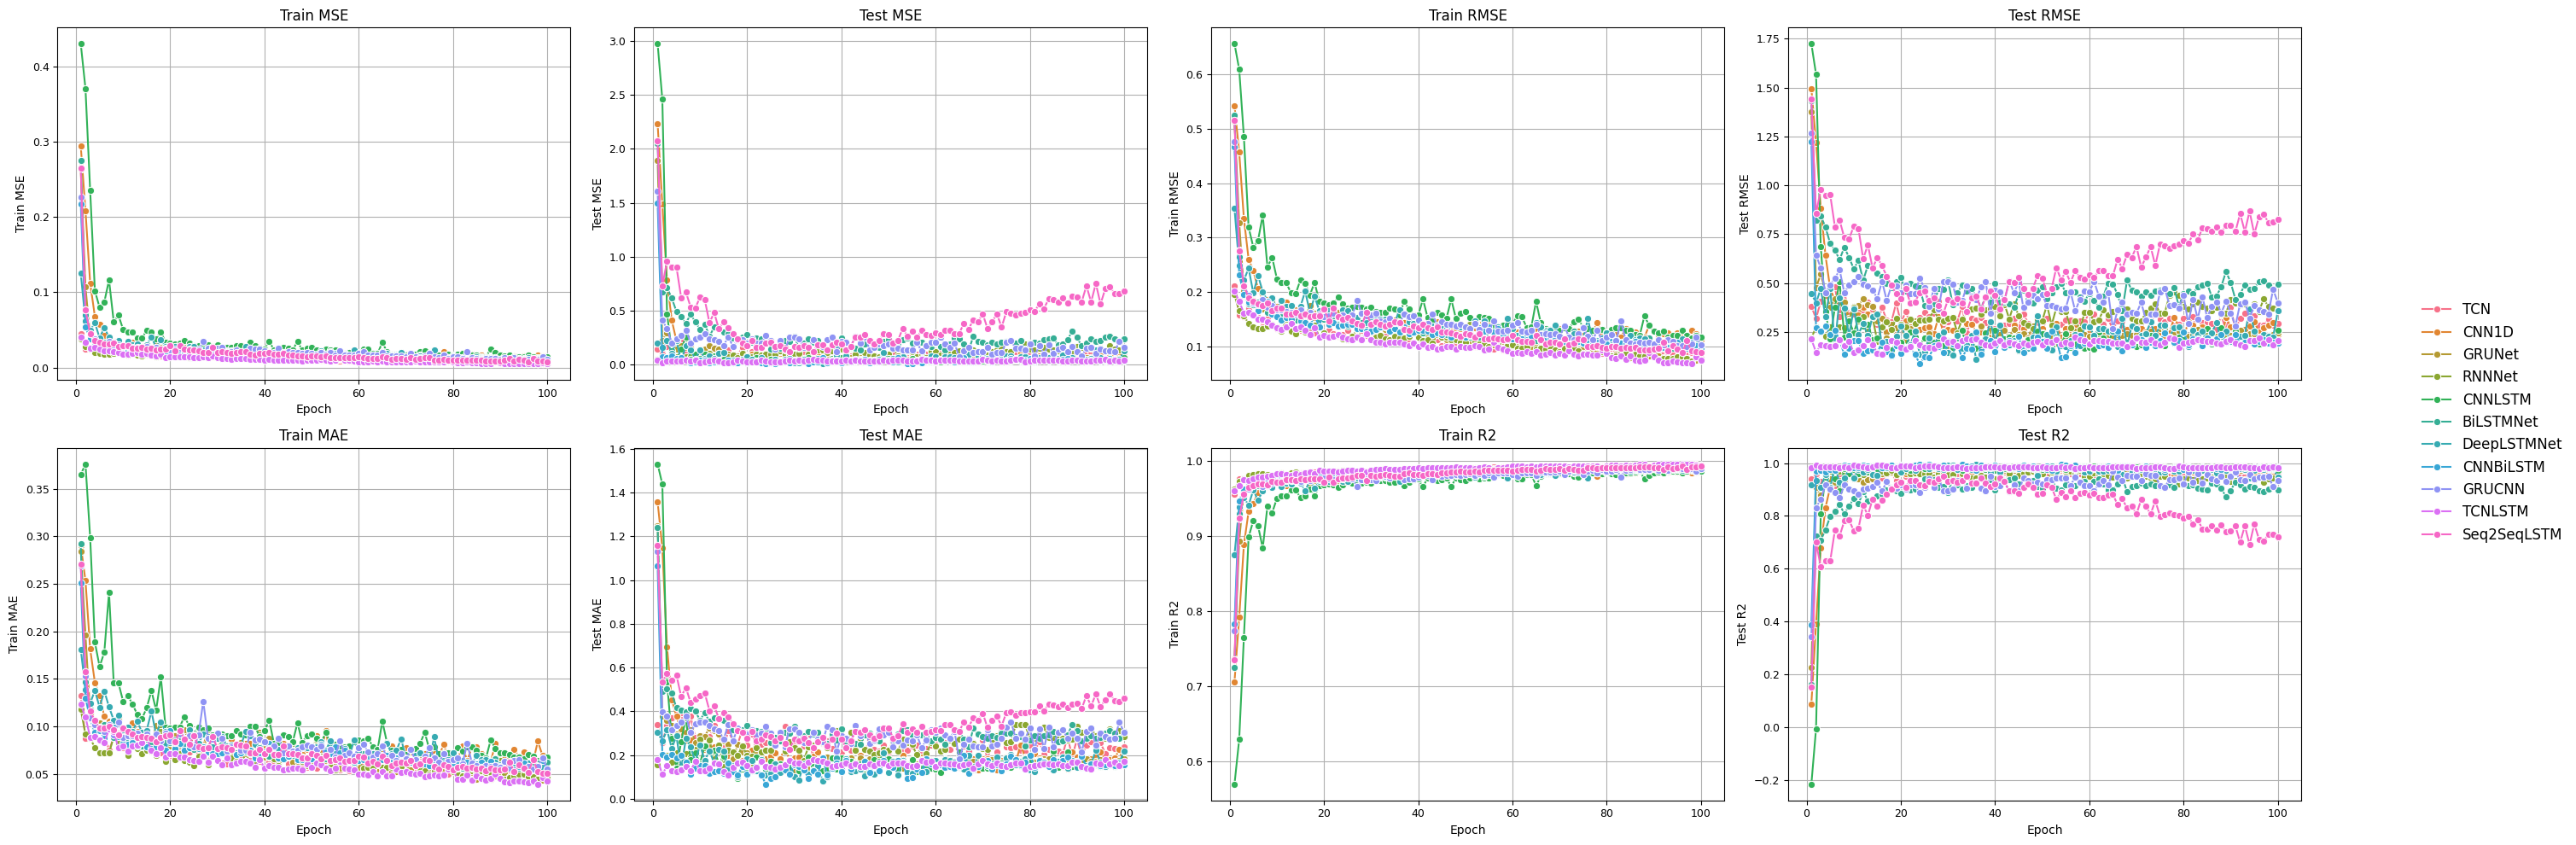

In [30]:
train_figures_ts = {}

models = ["TCN", "CNN1D", "GRUNet", "RNNNet", "CNNLSTM", "BiLSTMNet", 
          "DeepLSTMNet", "CNNBiLSTM", "GRUCNN", "TCNLSTM", "Seq2SeqLSTM"]

df_models = nn_metrics_ts_df[nn_metrics_ts_df["Model"].isin(models)]

n_metrics = len(metrics_to_plot)
ncols = 4
nrows = (n_metrics + ncols - 1) // ncols  

fig, axes = plt.subplots(nrows, ncols, figsize=(28, 10), sharey=False)
axes = axes.flatten()

handles, labels = None, None

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    sns.lineplot(data=df_models, x="Epoch", y=metric, hue="Model", marker='o', ax=ax)
    ax.set_title(metric, fontsize=12)
    ax.set_xlabel("Epoch", fontsize=10)
    ax.set_ylabel(metric, fontsize=10)
    ax.grid(True)
    ax.tick_params(labelsize=9)

    if handles is None and ax.get_legend():
        handles, labels = ax.get_legend_handles_labels()

    if ax.get_legend():
        ax.get_legend().remove()

for j in range(n_metrics, len(axes)):
    fig.delaxes(axes[j])
    
if handles and labels:
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.01, 0.5),
               fontsize="large", frameon=False)

plt.tight_layout(rect=[0, 0, 0.97, 1])  
train_figures_ts["Train_Metrics_TS"] = fig
plt.show()
plt.close()

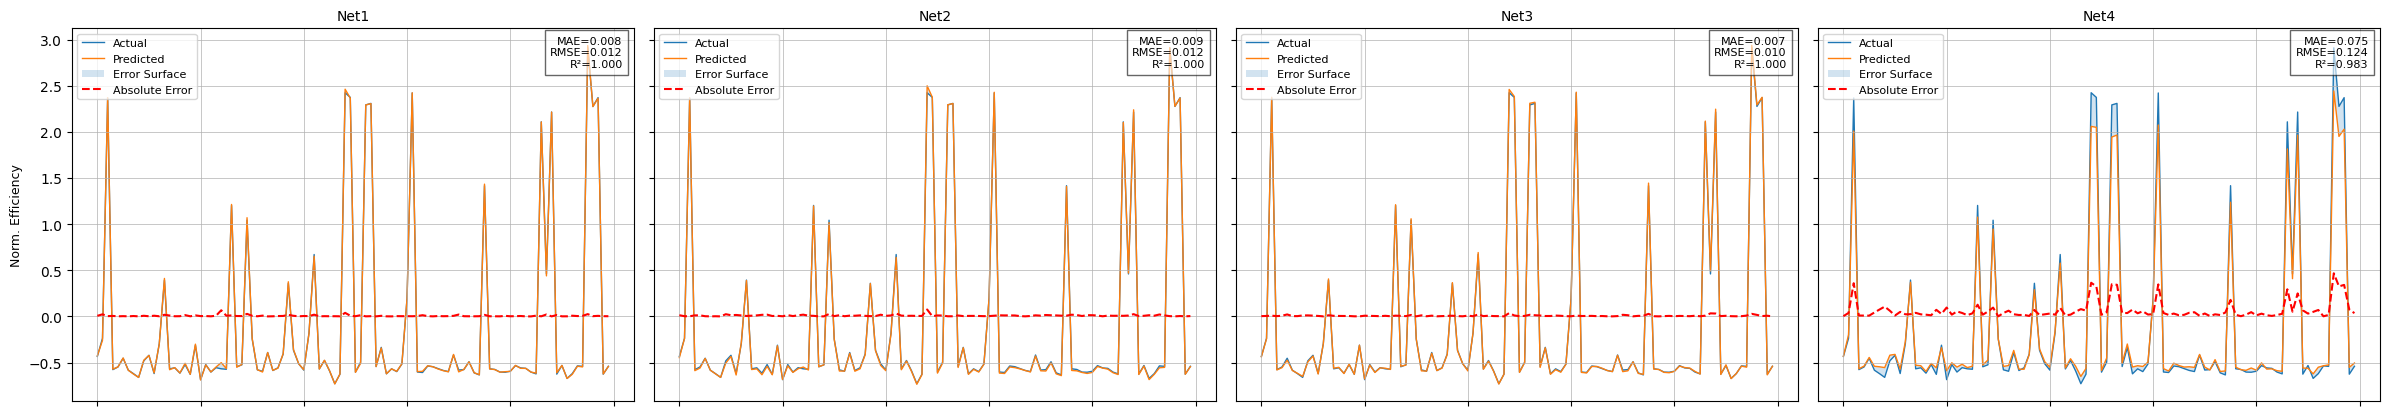

In [31]:
pred_figures_nets = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_models = len(nets)
ncols, nrows = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(24, 16),
                         sharex=True, sharey=True)
axes = axes.flatten()

desired = 100   
max_pts = 100

last_row_start = nrows * ncols - ncols
offset = (ncols - n_models % ncols) // 2 if n_models % ncols != 0 else 0

for i, (name, model) in enumerate(nets.items()):
    row = i // ncols
    col = i % ncols
    if row == nrows - 1 and n_models % ncols != 0:
        col += offset
    ax_index = row * ncols + col
    ax = axes[ax_index]

    model = model.to(device).eval()
    with torch.no_grad():
        X_in = reshape_input(model, X_test_tensor.to(device))
        preds = model(X_in).cpu().numpy().flatten()
        trues = y_test_tensor.cpu().numpy().flatten()

    avail = trues.shape[0]
    n_samples = min(desired, avail)
    y_t = trues[-n_samples:]
    y_p = preds[-n_samples:]
    err = np.abs(y_t - y_p)

    idx = np.linspace(0, n_samples - 1, min(n_samples, max_pts), dtype=int)
    
    ax.plot(idx, y_t[idx], label="Actual", lw=1, zorder=1)
    ax.plot(idx, y_p[idx], label="Predicted", lw=1, zorder=1)
    ax.fill_between(idx, y_t[idx], y_p[idx], alpha=0.2, label="Error Surface", zorder=0)
    ax.plot(idx, err[idx], '--', lw=1.5, color='red', label="Absolute Error", zorder=3)

    m = (nn_metrics_df.query("Model == @name").sort_values("Epoch").iloc[-1])
    stats = f"MAE={m['Test MAE']:.3f}\nRMSE={m['Test RMSE']:.3f}\nR²={m['Test R2']:.3f}"
    ax.text(0.98, 0.98, stats, transform=ax.transAxes,
            ha='right', va='top', fontsize=8,
            bbox=dict(facecolor='white', alpha=0.6))

    ax.set_title(name, fontsize=10)
    ax.grid(True, linewidth=0.5)

    if col == 0:
        ax.set_ylabel("Norm. Efficiency", fontsize=9)
    if row == nrows - 1:
        ax.set_xlabel("Sample Index", fontsize=9)

    ax.legend(fontsize=8, loc="upper left")

for j in range(n_models, nrows * ncols):
    fig.delaxes(axes[j])

plt.tight_layout()
pred_figures_nets["Prediction_Nets"] = fig
plt.show()
plt.close()

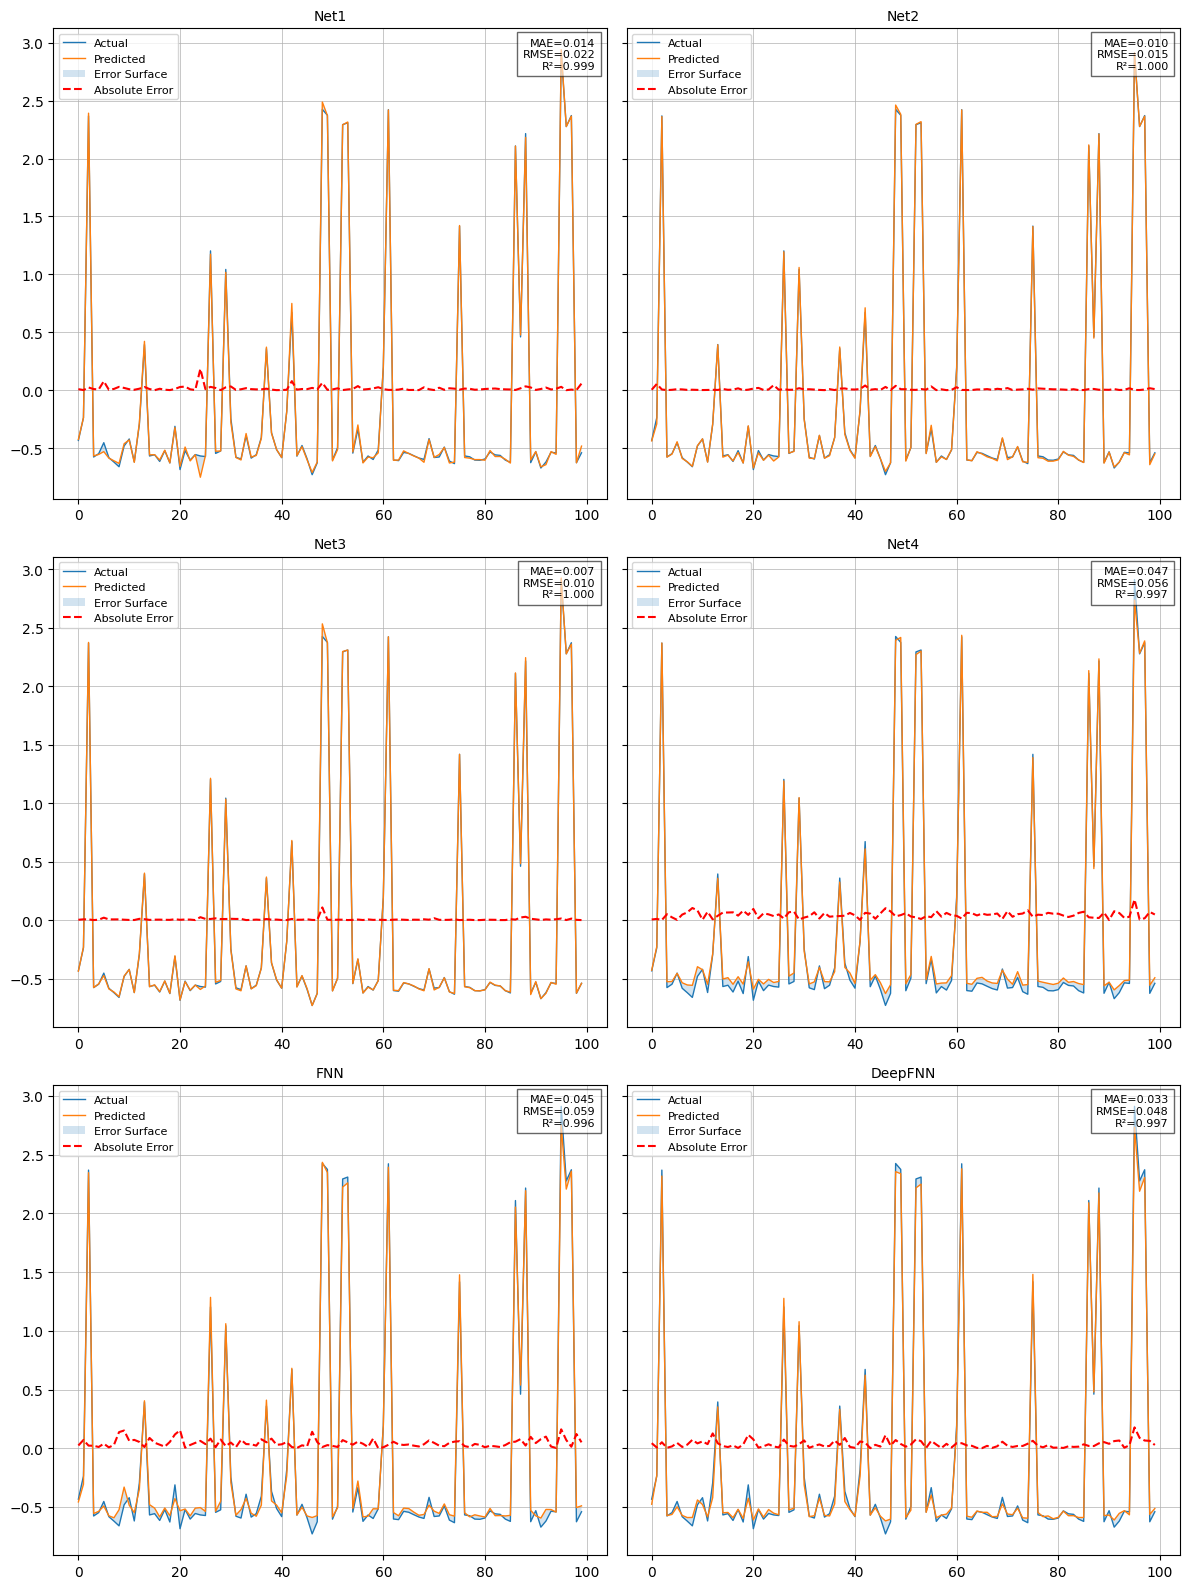

In [34]:
pred_figures_nets_tab = {}

n_models = len(nets_tabular)
nrows, ncols = 3, 2 

fig, axes = plt.subplots(nrows, ncols, figsize=(12, 16), sharey='row')
axes = axes.flatten()

model_items = list(nets_tabular.items())

for i, (name, model) in enumerate(model_items):
    ax = axes[i]
    model = model.to(device).eval()
    
    with torch.no_grad():
        X_in = reshape_input(model, X_test_tensor.to(device))
        preds = model(X_in).cpu().numpy().flatten()
        trues = y_test_tensor.cpu().numpy().flatten()

    avail = trues.shape[0]
    n_samples = min(100, avail)
    y_t = trues[-n_samples:]
    y_p = preds[-n_samples:]
    err = np.abs(y_t - y_p)
    idx = np.linspace(0, n_samples - 1, min(n_samples, 100), dtype=int)

    ax.plot(idx, y_t[idx], label="Actual", lw=1)
    ax.plot(idx, y_p[idx], label="Predicted", lw=1)
    ax.fill_between(idx, y_t[idx], y_p[idx], alpha=0.2, label="Error Surface")
    ax.plot(idx, err[idx], '--', lw=1.5, color='red', label="Absolute Error")

    m = nn_metrics_df_tabular.query("Model == @name").sort_values("Epoch").iloc[-1]
    stats = f"MAE={m['Test MAE']:.3f}\nRMSE={m['Test RMSE']:.3f}\nR²={m['Test R2']:.3f}"
    ax.text(0.98, 0.98, stats, transform=ax.transAxes,
            ha='right', va='top', fontsize=8,
            bbox=dict(facecolor='white', alpha=0.6))

    ax.set_title(name, fontsize=10)
    ax.grid(True, linewidth=0.5)
    ax.legend(fontsize=8, loc="upper left")

for j in range(len(model_items), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
pred_figures_nets_tab["Prediction_Nets_Tab"] = fig
plt.show()
plt.close()

/var/folders/x0/t4xvycdd6mz7b1y2rk0pl9mw0000gn/T/ipykernel_9394/743814915.py:60: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/var/folders/x0/t4xvycdd6mz7b1y2rk0pl9mw0000gn/T/ipykernel_9394/743814915.py:60: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


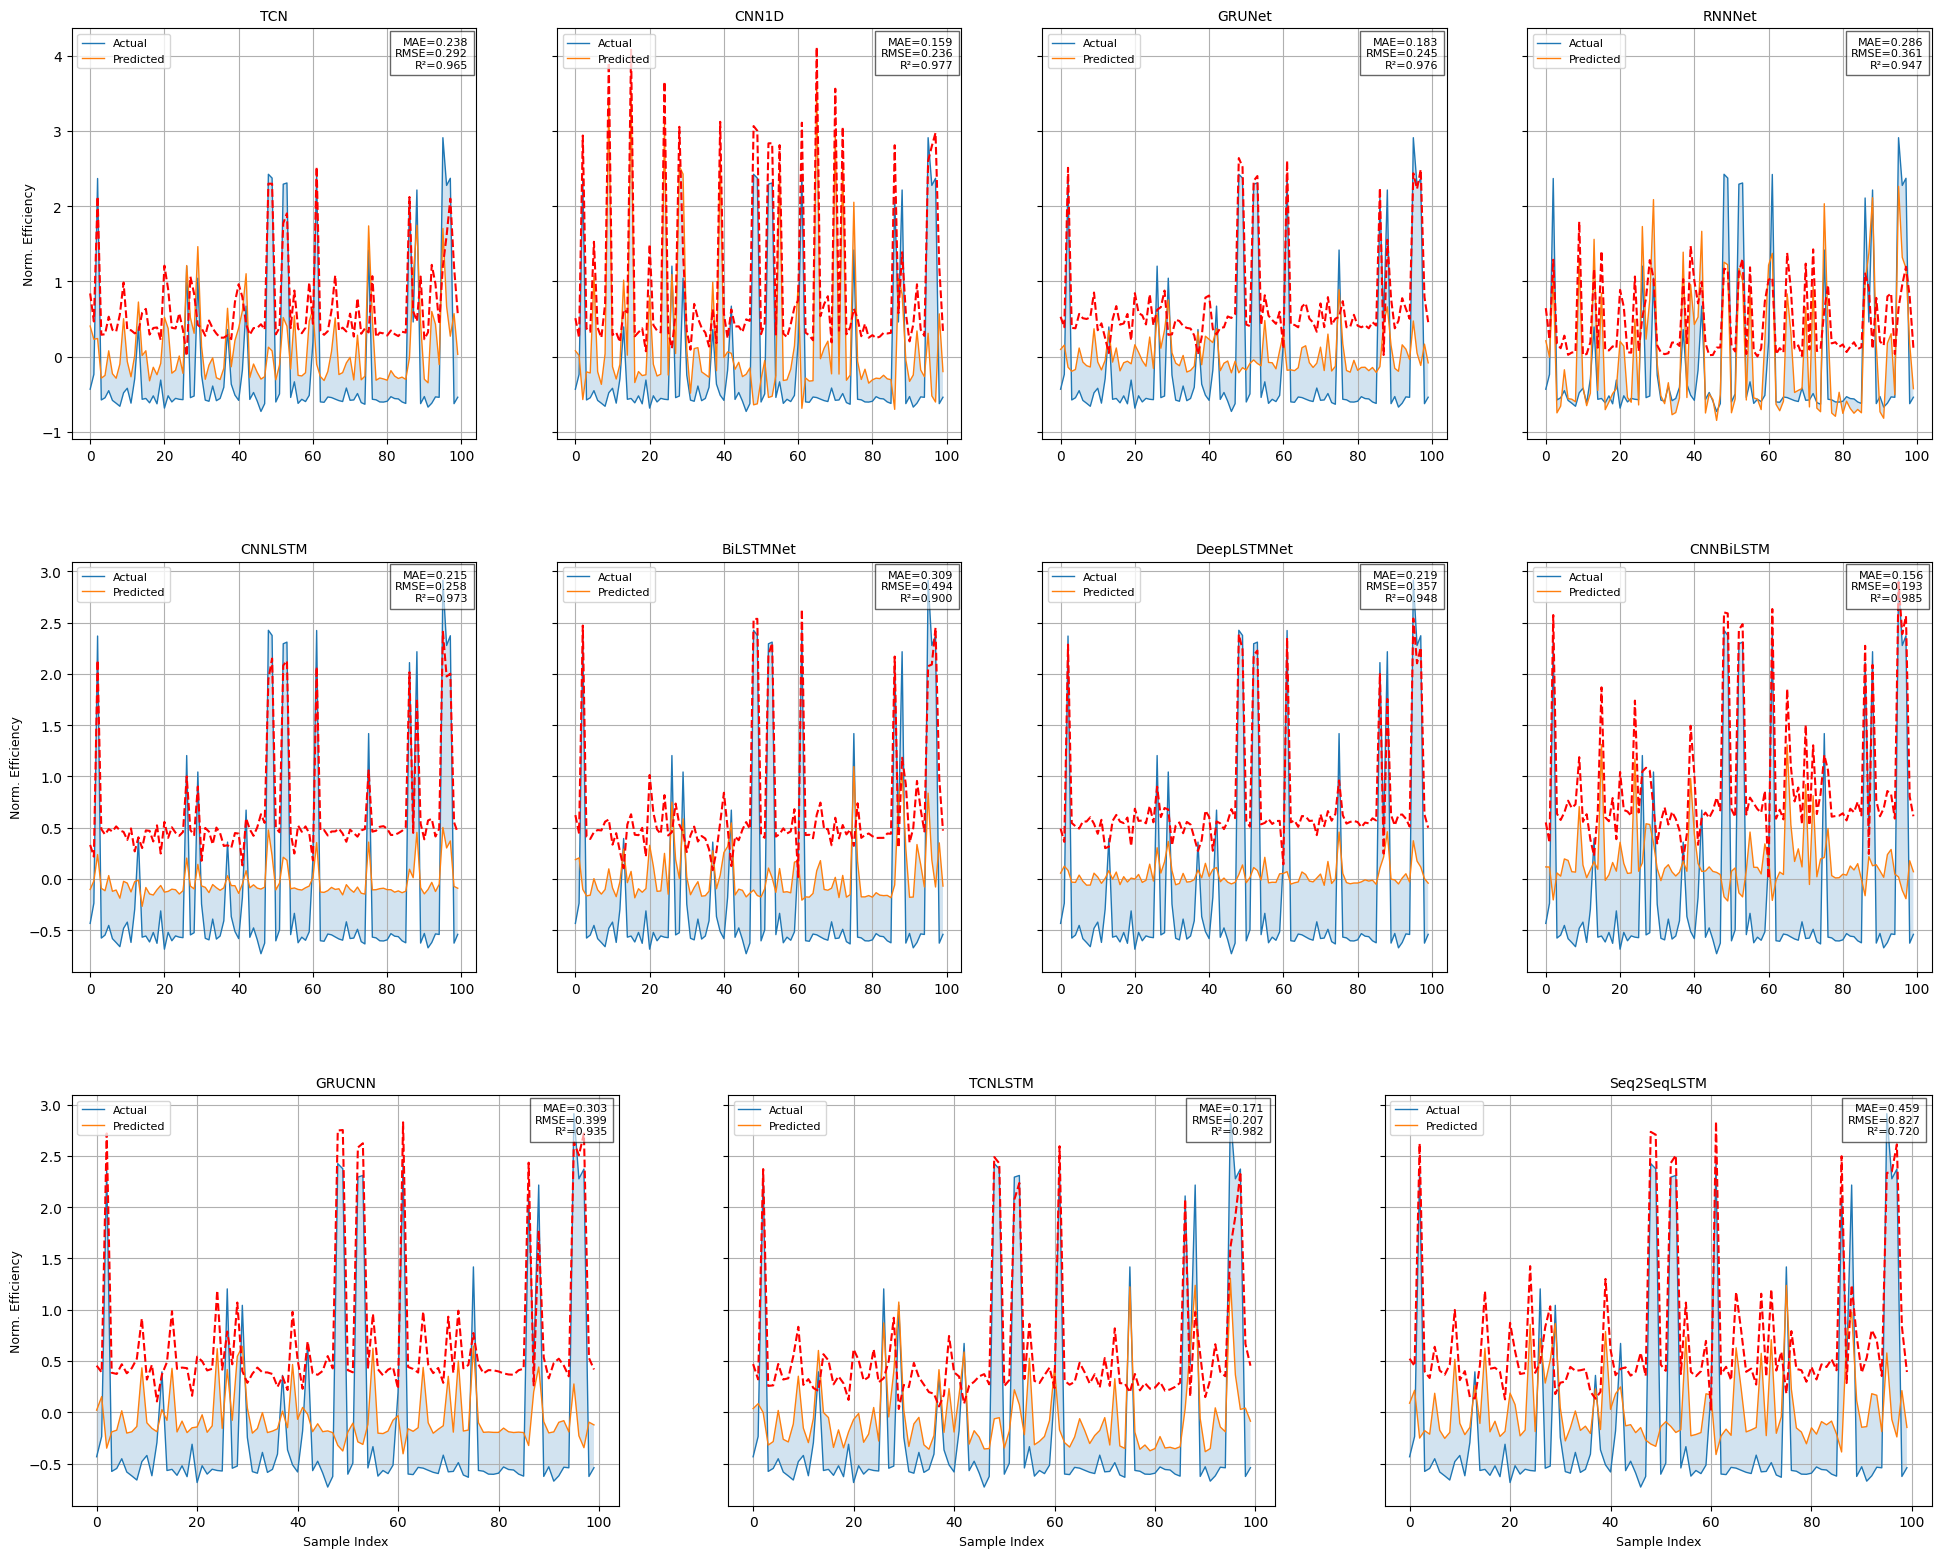

In [50]:
pred_figures_nets_ts = {}
n_models = len(ts_nets)
ncols = 4
full_rows = n_models // ncols   # 2
remainder = n_models % ncols

fig = plt.figure(constrained_layout=True,
                 figsize=(24, 16))
subfigs = fig.subfigures(full_rows + 1, 1,
                         height_ratios=[1]*full_rows + [1])

def plot_model(ax, name, model):
    model = model.to(device).eval()
    with torch.no_grad():
        X_in = reshape_input(model, X_test_tensor.to(device))
        preds = model(X_in).cpu().numpy().flatten()
        trues = y_test_tensor.cpu().numpy().flatten()
    n = min(100, len(trues))
    idxs = np.linspace(0, n - 1, min(n, 100), dtype=int)
    y_t, y_p = trues[-n:][idxs], preds[-n:][idxs]
    err = np.abs(y_t - y_p)
    ax.plot(idxs, y_t, label="Actual", lw=1)
    ax.plot(idxs, y_p, label="Predicted", lw=1)
    ax.fill_between(idxs, y_t, y_p, alpha=0.2)
    ax.plot(idxs, err, '--', lw=1.5, color='red')
    m = nn_metrics_ts_df.query("Model == @name") \
                        .sort_values("Epoch") \
                        .iloc[-1]
    stats = f"MAE={m['Test MAE']:.3f}\nRMSE={m['Test RMSE']:.3f}\nR²={m['Test R2']:.3f}"
    ax.text(0.98, 0.98, stats,
            transform=ax.transAxes,
            ha='right', va='top',
            fontsize=8,
            bbox=dict(facecolor='white', alpha=0.6))
    ax.set_title(name, fontsize=10)
    ax.grid(True)
    ax.legend(fontsize=8, loc="upper left")

for i in range(full_rows):
    axs = subfigs[i].subplots(1, ncols,
                              sharex=True,
                              sharey=True)
    for ax, (name, model) in zip(axs, list(ts_nets.items())[i * ncols:(i + 1) * ncols]):
        plot_model(ax, name, model)
    for ax in axs:
        if axs.tolist().index(ax) == 0:
            ax.set_ylabel("Norm. Efficiency", fontsize=9)
        if i == full_rows: 
            ax.set_xlabel("Sample Index", fontsize=9)

axs_last = subfigs[full_rows].subplots(1, remainder,
                                        sharex=True,
                                        sharey=True)
for ax, (name, model) in zip(axs_last, list(ts_nets.items())[full_rows * ncols :]):
    plot_model(ax, name, model)
    if axs_last.tolist().index(ax) == 0:
        ax.set_ylabel("Norm. Efficiency", fontsize=9)
    ax.set_xlabel("Sample Index", fontsize=9)

plt.tight_layout()
pred_figures_nets_ts["Prediction_Nets_TS"] = fig
plt.show()
plt.close()

In [51]:
save_ml_experiment(
    station="Amberd3",
    results=results,
    y_test=y_test,
    metrics_df=metrics_df,
    table_fig=table_fig,
    barplot_fig=barplot_fig,
    pred_figs=pred_figs,
    models_dict=models,
    base_dir=Path("..")
)


In [52]:
for name, model in nets.items():
    save_experiment(
        station="Amberd3",
        model_name=name,
        net=model,
        metrics_df=nn_metrics_df[nn_metrics_df["Model"] == name],
        train_figs=train_figures,
        pred_figs=pred_figures_nets,
        base_dir=Path("..")
    )

In [53]:
for name, model in nets_tabular.items():
    save_experiment(
        station="Amberd3",
        model_name=name,
        net=model,
        metrics_df=nn_metrics_df_tabular[nn_metrics_df_tabular["Model"] == name],
        train_figs=train_figures_tabular,
        pred_figs= pred_figures_nets_tab,
        base_dir=Path("..")
    )

In [54]:
for name, model in ts_nets.items():
    save_experiment(
        station="Amberd3",
        model_name=name,
        net=model,
        metrics_df=nn_metrics_ts_df[nn_metrics_ts_df["Model"] == name],
        train_figs=train_figures_ts,
        pred_figs=pred_figures_nets_ts,
        base_dir=Path("..")
    )